In [1]:
!pip install ftfy regex

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
from torch import log
from tqdm import tqdm
import torch
import torch.nn.functional as F
import torch.nn as nn
import argparse
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix

from dataloader.cobot_loader import load_cobot_data, Cdata_generator, CConfig

from models.DDNet_Original import DDNet_Original as DDNet
from utils import makedir
import sys
import time
import numpy as np
import logging

import clip
from KLLoss import KLLoss
import warnings
warnings.filterwarnings("ignore")


/home/dev/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
list_of_texts = ["Pointing with one finger: This action involves using a single finger, typically the index finger, to indicate or select something on the computer screen. It is commonly used with a computer mouse or touchpad to move the cursor and click on icons or links.",
"Pointing with two fingers: Pointing with two fingers is often used with touchpad gestures on laptops or touch-sensitive screens. It allows users to move the cursor or navigate through content on the screen by dragging two fingers in the desired direction.",
"Click with one finger: Clicking with one finger refers to pressing down with a single finger on a mouse button or touchpad to select or activate an element on the screen. It's a fundamental interaction for most computer operations.",
"Click with two fingers: Some touchpad devices support multi-touch gestures, where clicking with two fingers can have different functions, such as opening context menus or performing other specific actions.",
"Zoom in: To zoom in on a touchscreen or trackpad, users simply pinch two fingers together, making on-screen content appear larger for a closer look.",
"Zoom out:  When you need a broader view on a touchscreen or trackpad, spreading two fingers apart achieves a zoom-out effect, reducing the size of on-screen content."]

In [3]:
prefix = "A person "
list_of_texts = [
f'{prefix} does nothing',
f'{prefix}Raise one arm up high, make a fist, then keep the fist still, bend the arm to shoulder level, then raise it up again.,'

f'{prefix}Place one hand in front of your chest. Then move the arm in the opposite direction.',

f'{prefix}Place your arms vertical and perpendicular to the ground at shoulder level when your arms are bent. Then bring it back to your chest.',

f'{prefix}Raise one hand at chest level, palm facing down, tip of the hand facing out, then press the hand down to hip level, then lift the arm up and bring it back to the original position.',

f'{prefix}Place one hand flat on your hip, tip of the hand facing outward. Then, lift the hand lying face up to chest level, then press the hand down again and return to the starting position.',

f'{prefix}Place one arm across your chest, palm facing down, tip of the hand facing the opposite hand. Then, move your arm along the chest plane at an angle of more than 120 degrees, at which time the tip of your hand points outward. Finally return your arms to the starting position.',

f'{prefix}Raise one arm overhead, holding the hand, then move the arm and keep the holding hand towards the top of the head. Finally, return your arms to the starting position.',

f'{prefix}Raise one arm horizontally across the chest, vertical and perpendicular to the ground, hand with one index finger pointing up to the sky. Then, move your arm and index finger up until your arm is at shoulder level. Finally, return to the original position.',

f'{prefix}Raise one arm, place the hand on one half of the head.',

f'{prefix}Place one arm across your chest, vertical to your body, perpendicular to the ground. Raise your index finger and thumb normally, with your index finger pointing toward the sky.',

f'{prefix}Place your arms in front of your chest, clasp your hands, spread out only your thumbs, stand up and face the sky. Hold your hands facing in front of your body.',

f'{prefix}Place your arms in front of your chest, hands open and facing each other, palm tips facing the sky.',

f'{prefix}Place your arms across your chest, your hands close together (about a few centimeters), your palms facing each other.',

f'{prefix}Place one arm in front of your chest, vertical to the body. Palms face out in front of the body, fingers clustered in a claw shape.',

f'{prefix}Place one arm in front of your chest, vertical to the body. Hands clenched.',

f'{prefix}Place your hands across your chest, arms pointing out in front of your body. The hand bends the ring finger and little finger, the middle finger contacts the thumb, and the index finger spreads out naturally.',

f'{prefix}Place one arm across the neck, the arm horizontally perpendicular to the body axis, the tip of the hand facing the opposite shoulder. The other arm places the hand in front of the chest perpendicular to the palm of the other hand, the tip of the hand facing up.',

f'{prefix}Place one hand on the opposite shoulder, arms spread out with five fingers embracing one shoulder.',
f'{prefix}Place one hand on the opposite shoulder, placing the hand close to the shoulder. Hold the 3 thumbs, ring finger and little finger, and spread the index and middle fingers.',
f'{prefix}Raise one arm in front of your chest, arm vertical to the body axis. The fingers spread out and come together at one point, the tips of the hands facing the front of the body.']
# Now, you have a list of detailed action descriptions.
len(list_of_texts)


20

In [13]:



list_of_labels  = ['START',
'STOP',
'SLOWER',
'FASTER',
'DONE',
'FOLLOW ME',
'LIFT',
'HOME',
'LOOK',
'OK',
'HELP',
'AGAIN',
'PICKPART',
'DEPOSIT PART',
'INTERACTION',
'JOYSTICK',
'IDENTIFICATION',
'CHANGE',
'REPORT',]


a = ['Start', 'Stop', 'Slower', 'Faster', 'Done', 'FollowMe', 'Lift', 'Home', 'Interaction', 'Look', 'PickPart', 'DepositPart', 'Report', 'Ok', 'Again', 'Help', 'Joystick', 'Identification', 'Change']
b = ['START', 'STOP', 'SLOWER', 'FASTER', 'DONE', 'FOLLOW ME', 'LIFT', 'HOME', 'LOOK', 'OK', 'HELP', 'AGAIN', 'PICKPART', 'DEPOSIT PART', 'INTERACTION', 'JOYSTICK', 'IDENTIFICATION', 'CHANGE', 'REPORT']

# Convert both lists to lowercase for comparison
a_lower = [item.lower() for item in a]
b_lower = [item.lower().replace(' ', '') for item in b]

# Get the order of items in list b based on list a
# Create a dictionary with the order of items in list a
order = {item: i for i, item in enumerate(a_lower)}

# Sort list b based on the order in list a
list_of_texts_sorted = sorted(list_of_texts, key=lambda item: order.get(item.lower().replace(' ', ''), float('inf')))

print(list_of_texts_sorted)

['A person does nothing.', 'A person raises one arm up high, makes a fist, then keeps the fist still, bends the arm to shoulder level, then raises it up again.', 'A person places one hand in front of their chest, then moves the arm in the opposite direction.', 'A person places their arms vertically and perpendicular to the ground at shoulder level when their arms are bent. Then brings them back to their chest.', 'A person raises one hand at chest level, palm facing down, tip of the hand facing out, then presses the hand down to hip level, then lifts the arm up and brings it back to the original position.', 'A person places one hand flat on their hip, tip of the hand facing outward. Then, lifts the hand lying face up to chest level, then presses the hand down again and returns to the starting position.', 'A person places one arm across their chest, palm facing down, tip of the hand facing the opposite hand. Then, moves their arm along the chest plane at an angle of more than 120 degrees

In [12]:
model_text_name = "RN50"
device = "cuda:0"

def text_prompt_openai_random():
    #print("Use text prompt openai")


    return clip.tokenize(list_of_texts_sorted)


class TextCLIP(nn.Module):
    def __init__(self, model) :
        super(TextCLIP, self).__init__()
        self.model = model.float()

    def forward(self,text):
        return self.model.encode_text(text)

token_list = torch.tensor(np.array(text_prompt_openai_random()))
token_list = token_list.to(device)

model_, preprocess = clip.load(model_text_name, device)
model_text = TextCLIP(model_)
model_text = model_text.cuda(device)


In [6]:
sys.path.insert(0, './pytorch-summary/torchsummary/')
from torchsummary import summary  # noqa

savedir = Path('experiments') / Path(str(int(time.time())))
makedir(savedir)
logging.basicConfig(filename=savedir/'train.log', level=logging.INFO)
history = {
    "train_loss": [],
    "test_loss": [],
    "test_acc": []
}
#
args = None
save_model = True
log_interval = 100


In [7]:
def create_logits(x1, x2, logit_scale=10):
    x1 = x1 / x1.norm(dim=-1, keepdim=True)
    x2 = x2 / x2.norm(dim=-1, keepdim=True)

    # cosine similarity as logits
    logits_per_x1 = logit_scale * x1 @ x2.t()
    logits_per_x2 = logit_scale * x2 @ x1.t()

    # shape = [global_batch_size, global_batch_size]
    return logits_per_x1, logits_per_x2

def gen_label(labels):
    num = len(labels)
    gt = np.zeros(shape=(num,num))
    for i, label in enumerate(labels):
        for k in range(num):
            if labels[k] == label:
                gt[i,k] = 1
    return gt

In [8]:
def train(args, model, text_model, token_list, device, train_loader, optimizer, epoch, criterion, KLloss):
    model.train()

    #token_list = token_list.to(device)
    train_loss = 0
    text_loss_mean = 0
    for batch_idx, (data1, data2, target) in enumerate(tqdm(train_loader)):
        M, P, target = data1.to(device), data2.to(device), target.to(device)
        label_g = gen_label(target)

        optimizer.zero_grad()
        output, _features = model(M, P)
        # get target token

        target_token_list = list()
        for i in range(target.size(0)):
            target_token_list.append(token_list[target[i].item()])
        target_token_list = torch.tensor(np.array(target_token_list))
        target_token_list = target_token_list.to(device)
        text_embedding = text_model(target_token_list).float()
        #print(_features.size())
        logits_per_image, logits_per_text = create_logits(_features,text_embedding, 1)
        ground_truth = torch.tensor(label_g,dtype=text_embedding.dtype,device=device)
        loss_imgs = KLloss(logits_per_image,ground_truth)
        loss_texts = KLloss(logits_per_text,ground_truth)
        text_loss_mean += (loss_texts).detach().item()

        #cosine_similarity_1 = F.cosine_similarity(text_embedding, _features, dim=1)
        #cosine_similarity_2 = F.cosine_similarity(_features, text_embedding, dim=1)
        #print(loss_imgs, loss_texts)
        loss = 0.5*criterion(output, target) + 0.5*(loss_imgs+loss_texts)/2
        #loss = criterion(output, target)

        train_loss += loss.detach().item()
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            msg = ('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data1), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            print(msg)
            logging.info(msg)
            dry_run = False
            if dry_run:
                break
    print("mean text_img_loss:", text_loss_mean/(batch_idx))
    history['train_loss'].append(train_loss)
    return train_loss


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for _, (data1, data2, target) in enumerate(tqdm(test_loader)):
            M, P, target = data1.to(device), data2.to(device), target.to(device)
            output, _features = model(M, P)
            # sum up batch loss
            test_loss += criterion(output, target).item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            # output shape (B,Class)
            # target_shape (B)
            # pred shape (B,1)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(correct / len(test_loader.dataset))
    msg = ('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    print(msg)
    logging.info(msg)

In [9]:
device = torch.device("cuda")
kwargs = {'batch_size': 16}
kwargs.update({'num_workers': 12,
                    'pin_memory': True,
                    'shuffle': True},)

Config = CConfig()
data_generator = Cdata_generator
load_data = load_cobot_data
clc_num = Config.clc_num

In [10]:
C = Config
Train, Test, le = load_cobot_data()
X_0, X_1, Y = data_generator(Train, C, le)
X_0 = torch.from_numpy(X_0).type('torch.FloatTensor')
X_1 = torch.from_numpy(X_1).type('torch.FloatTensor')
Y = torch.from_numpy(Y).type('torch.LongTensor')

X_0_t, X_1_t, Y_t = data_generator(Test, C, le)
X_0_t = torch.from_numpy(X_0_t).type('torch.FloatTensor')
X_1_t = torch.from_numpy(X_1_t).type('torch.FloatTensor')
Y_t = torch.from_numpy(Y_t).type('torch.LongTensor')

trainset = torch.utils.data.TensorDataset(X_0, X_1, Y)
train_loader = torch.utils.data.DataLoader(trainset, **kwargs)

testset = torch.utils.data.TensorDataset(X_0_t, X_1_t, Y_t)
test_loader = torch.utils.data.DataLoader(
    testset, batch_size=16)

Done


100%|██████████| 855/855 [00:28<00:00, 29.61it/s]


=========using KL Loss=and has temperature and * bz==========


  1%|          | 1/155 [00:02<06:07,  2.39s/it]

Train Epoch: 1 [0/2478 (0%)]	Loss: 2.428042


 65%|██████▌   | 101/155 [00:43<00:25,  2.08it/s]

Train Epoch: 1 [1600/2478 (65%)]	Loss: 2.464754


100%|██████████| 155/155 [01:04<00:00,  2.39it/s]


mean text_img_loss: 2.1436111524507595


100%|██████████| 54/54 [00:00<00:00, 75.13it/s]


Test set: Average loss: 2.6905, Accuracy: 135/855 (15.79%)



  1%|          | 1/155 [00:01<03:27,  1.35s/it]

Train Epoch: 2 [0/2478 (0%)]	Loss: 2.142588


 65%|██████▌   | 101/155 [00:42<00:25,  2.08it/s]

Train Epoch: 2 [1600/2478 (65%)]	Loss: 2.371264


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.9859873350564536


100%|██████████| 54/54 [00:00<00:00, 81.27it/s]


Test set: Average loss: 1.9012, Accuracy: 309/855 (36.14%)



  1%|          | 1/155 [00:01<03:40,  1.43s/it]

Train Epoch: 3 [0/2478 (0%)]	Loss: 2.049833


 66%|██████▌   | 102/155 [00:42<00:20,  2.54it/s]

Train Epoch: 3 [1600/2478 (65%)]	Loss: 1.833510


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.939626005562869


100%|██████████| 54/54 [00:00<00:00, 77.87it/s]


Test set: Average loss: 1.6362, Accuracy: 344/855 (40.23%)



  1%|          | 1/155 [00:01<03:31,  1.37s/it]

Train Epoch: 4 [0/2478 (0%)]	Loss: 1.711874


 66%|██████▌   | 102/155 [00:42<00:20,  2.54it/s]

Train Epoch: 4 [1600/2478 (65%)]	Loss: 1.866181


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.8540143788634957


100%|██████████| 54/54 [00:00<00:00, 79.62it/s]


Test set: Average loss: 1.6113, Accuracy: 345/855 (40.35%)



  1%|          | 1/155 [00:01<03:34,  1.39s/it]

Train Epoch: 5 [0/2478 (0%)]	Loss: 1.726616


 66%|██████▌   | 102/155 [00:42<00:21,  2.52it/s]

Train Epoch: 5 [1600/2478 (65%)]	Loss: 1.433717


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.784275938164104


100%|██████████| 54/54 [00:00<00:00, 81.47it/s]


Test set: Average loss: 1.3620, Accuracy: 415/855 (48.54%)



  1%|          | 1/155 [00:01<03:34,  1.39s/it]

Train Epoch: 6 [0/2478 (0%)]	Loss: 1.267561


 66%|██████▌   | 102/155 [00:42<00:20,  2.54it/s]

Train Epoch: 6 [1600/2478 (65%)]	Loss: 1.538768


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.7714669278689794


100%|██████████| 54/54 [00:00<00:00, 80.74it/s]


Test set: Average loss: 1.3124, Accuracy: 453/855 (52.98%)



  1%|          | 1/155 [00:01<03:39,  1.42s/it]

Train Epoch: 7 [0/2478 (0%)]	Loss: 1.386638


 66%|██████▌   | 102/155 [00:42<00:20,  2.55it/s]

Train Epoch: 7 [1600/2478 (65%)]	Loss: 1.737011


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.740028713430677


100%|██████████| 54/54 [00:00<00:00, 81.00it/s]


Test set: Average loss: 1.1065, Accuracy: 485/855 (56.73%)



  1%|          | 1/155 [00:01<03:35,  1.40s/it]

Train Epoch: 8 [0/2478 (0%)]	Loss: 1.396392


 66%|██████▌   | 102/155 [00:42<00:20,  2.54it/s]

Train Epoch: 8 [1600/2478 (65%)]	Loss: 1.596493


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.759117747282053


100%|██████████| 54/54 [00:00<00:00, 81.89it/s]


Test set: Average loss: 1.3764, Accuracy: 404/855 (47.25%)



  1%|          | 1/155 [00:01<03:39,  1.43s/it]

Train Epoch: 9 [0/2478 (0%)]	Loss: 1.179767


 66%|██████▌   | 102/155 [00:42<00:20,  2.55it/s]

Train Epoch: 9 [1600/2478 (65%)]	Loss: 1.402397


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.7382511233354543


100%|██████████| 54/54 [00:00<00:00, 79.83it/s]


Test set: Average loss: 1.0836, Accuracy: 510/855 (59.65%)



  1%|▏         | 2/155 [00:01<01:46,  1.43it/s]

Train Epoch: 10 [0/2478 (0%)]	Loss: 1.469654


 65%|██████▌   | 101/155 [00:42<00:25,  2.08it/s]

Train Epoch: 10 [1600/2478 (65%)]	Loss: 1.321258


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.7410237185366741


100%|██████████| 54/54 [00:00<00:00, 84.13it/s]


Test set: Average loss: 1.0684, Accuracy: 501/855 (58.60%)



  1%|          | 1/155 [00:01<03:38,  1.42s/it]

Train Epoch: 11 [0/2478 (0%)]	Loss: 1.196332


 65%|██████▌   | 101/155 [00:42<00:25,  2.08it/s]

Train Epoch: 11 [1600/2478 (65%)]	Loss: 1.814244


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.7508822826596049


100%|██████████| 54/54 [00:00<00:00, 80.59it/s]


Test set: Average loss: 1.2901, Accuracy: 484/855 (56.61%)



  1%|          | 1/155 [00:01<03:38,  1.42s/it]

Train Epoch: 12 [0/2478 (0%)]	Loss: 1.690948


 65%|██████▌   | 101/155 [00:42<00:25,  2.09it/s]

Train Epoch: 12 [1600/2478 (65%)]	Loss: 1.338392


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.8908898482074985


100%|██████████| 54/54 [00:00<00:00, 81.25it/s]


Test set: Average loss: 1.0742, Accuracy: 523/855 (61.17%)



  1%|          | 1/155 [00:01<03:37,  1.42s/it]

Train Epoch: 13 [0/2478 (0%)]	Loss: 1.332958


 66%|██████▌   | 102/155 [00:42<00:20,  2.54it/s]

Train Epoch: 13 [1600/2478 (65%)]	Loss: 1.739218


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.7405423367178285


100%|██████████| 54/54 [00:00<00:00, 80.92it/s]


Test set: Average loss: 1.1690, Accuracy: 511/855 (59.77%)



  1%|          | 1/155 [00:01<03:33,  1.38s/it]

Train Epoch: 14 [0/2478 (0%)]	Loss: 1.175593


 66%|██████▌   | 102/155 [00:42<00:20,  2.53it/s]

Train Epoch: 14 [1600/2478 (65%)]	Loss: 1.297662


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.717194244459078


100%|██████████| 54/54 [00:00<00:00, 80.84it/s]


Test set: Average loss: 1.0575, Accuracy: 510/855 (59.65%)



  1%|          | 1/155 [00:01<03:37,  1.41s/it]

Train Epoch: 15 [0/2478 (0%)]	Loss: 1.613849


 66%|██████▌   | 102/155 [00:42<00:20,  2.54it/s]

Train Epoch: 15 [1600/2478 (65%)]	Loss: 1.276150


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.6897202939182132


100%|██████████| 54/54 [00:00<00:00, 82.12it/s]


Test set: Average loss: 0.9715, Accuracy: 537/855 (62.81%)



  1%|▏         | 2/155 [00:01<01:45,  1.45it/s]

Train Epoch: 16 [0/2478 (0%)]	Loss: 1.416187


 66%|██████▌   | 102/155 [00:42<00:20,  2.56it/s]

Train Epoch: 16 [1600/2478 (65%)]	Loss: 1.601007


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.6913577805865894


100%|██████████| 54/54 [00:00<00:00, 77.22it/s]


Test set: Average loss: 1.1747, Accuracy: 506/855 (59.18%)



  1%|          | 1/155 [00:01<03:34,  1.39s/it]

Train Epoch: 17 [0/2478 (0%)]	Loss: 1.208892


 66%|██████▌   | 102/155 [00:42<00:20,  2.64it/s]

Train Epoch: 17 [1600/2478 (65%)]	Loss: 1.232247


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.6671277238177014


100%|██████████| 54/54 [00:00<00:00, 81.68it/s]


Test set: Average loss: 0.9355, Accuracy: 544/855 (63.63%)



  1%|          | 1/155 [00:01<03:32,  1.38s/it]

Train Epoch: 18 [0/2478 (0%)]	Loss: 1.272274


 66%|██████▌   | 102/155 [00:42<00:17,  3.03it/s]

Train Epoch: 18 [1600/2478 (65%)]	Loss: 1.019207


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.6586389750629276


100%|██████████| 54/54 [00:00<00:00, 77.73it/s]


Test set: Average loss: 0.9261, Accuracy: 550/855 (64.33%)



  1%|          | 1/155 [00:01<03:30,  1.37s/it]

Train Epoch: 19 [0/2478 (0%)]	Loss: 1.252229


 66%|██████▌   | 102/155 [00:41<00:14,  3.62it/s]

Train Epoch: 19 [1600/2478 (65%)]	Loss: 1.136418


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.6487164644451884


100%|██████████| 54/54 [00:00<00:00, 79.27it/s]


Test set: Average loss: 1.1064, Accuracy: 533/855 (62.34%)



  1%|          | 1/155 [00:01<03:34,  1.39s/it]

Train Epoch: 20 [0/2478 (0%)]	Loss: 1.261344


 65%|██████▌   | 101/155 [00:41<00:16,  3.35it/s]

Train Epoch: 20 [1600/2478 (65%)]	Loss: 1.194236


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.6279912962541951


100%|██████████| 54/54 [00:00<00:00, 83.95it/s]


Test set: Average loss: 0.9124, Accuracy: 567/855 (66.32%)



  1%|          | 1/155 [00:01<03:37,  1.41s/it]

Train Epoch: 21 [0/2478 (0%)]	Loss: 1.064025


 65%|██████▌   | 101/155 [00:41<00:20,  2.64it/s]

Train Epoch: 21 [1600/2478 (65%)]	Loss: 0.704086


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.587103752346782


100%|██████████| 54/54 [00:00<00:00, 80.61it/s]


Test set: Average loss: 0.9766, Accuracy: 535/855 (62.57%)



  1%|          | 1/155 [00:01<03:36,  1.41s/it]

Train Epoch: 22 [0/2478 (0%)]	Loss: 1.512830


 65%|██████▌   | 101/155 [00:41<00:23,  2.31it/s]

Train Epoch: 22 [1600/2478 (65%)]	Loss: 1.105732


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.587120705610746


100%|██████████| 54/54 [00:00<00:00, 83.11it/s]


Test set: Average loss: 0.9800, Accuracy: 549/855 (64.21%)



  1%|          | 1/155 [00:01<03:33,  1.39s/it]

Train Epoch: 23 [0/2478 (0%)]	Loss: 1.041899


 66%|██████▌   | 102/155 [00:41<00:19,  2.67it/s]

Train Epoch: 23 [1600/2478 (65%)]	Loss: 1.148418


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5927458049414993


100%|██████████| 54/54 [00:00<00:00, 79.94it/s]


Test set: Average loss: 0.9505, Accuracy: 560/855 (65.50%)



  1%|          | 1/155 [00:01<03:33,  1.38s/it]

Train Epoch: 24 [0/2478 (0%)]	Loss: 1.424149


 66%|██████▌   | 102/155 [00:41<00:20,  2.60it/s]

Train Epoch: 24 [1600/2478 (65%)]	Loss: 1.046960


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5774767677505295


100%|██████████| 54/54 [00:00<00:00, 80.65it/s]


Test set: Average loss: 1.0349, Accuracy: 550/855 (64.33%)



  1%|          | 1/155 [00:01<03:37,  1.41s/it]

Train Epoch: 25 [0/2478 (0%)]	Loss: 1.201358


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 25 [1600/2478 (65%)]	Loss: 1.106845


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.5610148132621469


100%|██████████| 54/54 [00:00<00:00, 81.52it/s]


Test set: Average loss: 1.0510, Accuracy: 561/855 (65.61%)



  1%|          | 1/155 [00:01<03:39,  1.42s/it]

Train Epoch: 26 [0/2478 (0%)]	Loss: 1.218329


 66%|██████▌   | 102/155 [00:41<00:20,  2.54it/s]

Train Epoch: 26 [1600/2478 (65%)]	Loss: 1.128383


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5426770526093323


100%|██████████| 54/54 [00:00<00:00, 83.81it/s]


Test set: Average loss: 0.8508, Accuracy: 591/855 (69.12%)



  1%|          | 1/155 [00:01<03:38,  1.42s/it]

Train Epoch: 27 [0/2478 (0%)]	Loss: 1.203155


 66%|██████▌   | 102/155 [00:41<00:20,  2.55it/s]

Train Epoch: 27 [1600/2478 (65%)]	Loss: 1.118128


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5599662808628825


100%|██████████| 54/54 [00:00<00:00, 77.53it/s]


Test set: Average loss: 0.8261, Accuracy: 586/855 (68.54%)



  1%|          | 1/155 [00:01<03:29,  1.36s/it]

Train Epoch: 28 [0/2478 (0%)]	Loss: 1.028756


 66%|██████▌   | 102/155 [00:41<00:20,  2.55it/s]

Train Epoch: 28 [1600/2478 (65%)]	Loss: 1.099589


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.5902073367849572


100%|██████████| 54/54 [00:00<00:00, 80.85it/s]


Test set: Average loss: 0.8380, Accuracy: 593/855 (69.36%)



  1%|          | 1/155 [00:01<03:33,  1.39s/it]

Train Epoch: 29 [0/2478 (0%)]	Loss: 1.546884


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 29 [1600/2478 (65%)]	Loss: 1.075443


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.6295536756515503


100%|██████████| 54/54 [00:00<00:00, 81.72it/s]


Test set: Average loss: 0.8337, Accuracy: 607/855 (70.99%)



  1%|          | 1/155 [00:01<03:38,  1.42s/it]

Train Epoch: 30 [0/2478 (0%)]	Loss: 1.101675


 66%|██████▌   | 102/155 [00:41<00:20,  2.54it/s]

Train Epoch: 30 [1600/2478 (65%)]	Loss: 1.302085


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.593652218967289


100%|██████████| 54/54 [00:00<00:00, 81.16it/s]


Test set: Average loss: 1.1071, Accuracy: 554/855 (64.80%)



  1%|          | 1/155 [00:01<03:36,  1.41s/it]

Train Epoch: 31 [0/2478 (0%)]	Loss: 1.084772


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 31 [1600/2478 (65%)]	Loss: 1.051432


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5752286469781553


100%|██████████| 54/54 [00:00<00:00, 81.58it/s]


Test set: Average loss: 1.1370, Accuracy: 580/855 (67.84%)



  1%|          | 1/155 [00:01<03:38,  1.42s/it]

Train Epoch: 32 [0/2478 (0%)]	Loss: 1.080012


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 32 [1600/2478 (65%)]	Loss: 1.025472


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.553228583428767


100%|██████████| 54/54 [00:00<00:00, 81.77it/s]


Test set: Average loss: 0.9363, Accuracy: 619/855 (72.40%)



  1%|          | 1/155 [00:01<03:36,  1.41s/it]

Train Epoch: 33 [0/2478 (0%)]	Loss: 0.873386


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 33 [1600/2478 (65%)]	Loss: 0.938307


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5876452636409115


100%|██████████| 54/54 [00:00<00:00, 82.53it/s]


Test set: Average loss: 0.7596, Accuracy: 626/855 (73.22%)



  1%|          | 1/155 [00:01<03:42,  1.44s/it]

Train Epoch: 34 [0/2478 (0%)]	Loss: 0.938563


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 34 [1600/2478 (65%)]	Loss: 1.291255


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.561988664911939


100%|██████████| 54/54 [00:00<00:00, 79.09it/s]


Test set: Average loss: 0.8245, Accuracy: 611/855 (71.46%)



  1%|          | 1/155 [00:01<03:34,  1.39s/it]

Train Epoch: 35 [0/2478 (0%)]	Loss: 1.104822


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 35 [1600/2478 (65%)]	Loss: 1.036259


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5534308219884898


100%|██████████| 54/54 [00:00<00:00, 78.86it/s]


Test set: Average loss: 1.1057, Accuracy: 605/855 (70.76%)



  1%|          | 1/155 [00:01<03:36,  1.41s/it]

Train Epoch: 36 [0/2478 (0%)]	Loss: 1.142923


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 36 [1600/2478 (65%)]	Loss: 1.047054


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5450481896276598


100%|██████████| 54/54 [00:00<00:00, 80.86it/s]


Test set: Average loss: 0.9244, Accuracy: 599/855 (70.06%)



  1%|          | 1/155 [00:01<03:36,  1.40s/it]

Train Epoch: 37 [0/2478 (0%)]	Loss: 1.007166


 65%|██████▌   | 101/155 [00:41<00:25,  2.10it/s]

Train Epoch: 37 [1600/2478 (65%)]	Loss: 1.147505


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.5386686092847353


100%|██████████| 54/54 [00:00<00:00, 78.20it/s]


Test set: Average loss: 0.7270, Accuracy: 614/855 (71.81%)



  1%|          | 1/155 [00:01<03:58,  1.55s/it]

Train Epoch: 38 [0/2478 (0%)]	Loss: 0.924178


 66%|██████▌   | 102/155 [00:41<00:20,  2.53it/s]

Train Epoch: 38 [1600/2478 (65%)]	Loss: 0.976938


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.5386933808202867


100%|██████████| 54/54 [00:00<00:00, 79.53it/s]


Test set: Average loss: 0.8610, Accuracy: 609/855 (71.23%)



  1%|          | 1/155 [00:01<03:34,  1.39s/it]

Train Epoch: 39 [0/2478 (0%)]	Loss: 1.098857


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 39 [1600/2478 (65%)]	Loss: 0.906033


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5408300548404843


100%|██████████| 54/54 [00:00<00:00, 76.86it/s]


Test set: Average loss: 0.7618, Accuracy: 626/855 (73.22%)



  1%|          | 1/155 [00:01<03:55,  1.53s/it]

Train Epoch: 40 [0/2478 (0%)]	Loss: 1.051651


 66%|██████▌   | 102/155 [00:41<00:20,  2.53it/s]

Train Epoch: 40 [1600/2478 (65%)]	Loss: 1.109482


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.5402611854014459


100%|██████████| 54/54 [00:00<00:00, 82.08it/s]


Test set: Average loss: 0.7942, Accuracy: 640/855 (74.85%)



  1%|          | 1/155 [00:01<03:38,  1.42s/it]

Train Epoch: 41 [0/2478 (0%)]	Loss: 1.036017


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 41 [1600/2478 (65%)]	Loss: 1.016637


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.553218481602607


100%|██████████| 54/54 [00:00<00:00, 73.38it/s]


Test set: Average loss: 0.7609, Accuracy: 644/855 (75.32%)



  1%|          | 1/155 [00:01<03:29,  1.36s/it]

Train Epoch: 42 [0/2478 (0%)]	Loss: 1.010579


 65%|██████▌   | 101/155 [00:41<00:25,  2.11it/s]

Train Epoch: 42 [1600/2478 (65%)]	Loss: 1.012448


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5306677849261792


100%|██████████| 54/54 [00:00<00:00, 80.61it/s]


Test set: Average loss: 0.6834, Accuracy: 652/855 (76.26%)



  1%|          | 1/155 [00:01<03:31,  1.38s/it]

Train Epoch: 43 [0/2478 (0%)]	Loss: 1.000923


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 43 [1600/2478 (65%)]	Loss: 1.162036


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5411650925487668


100%|██████████| 54/54 [00:00<00:00, 76.59it/s]


Test set: Average loss: 0.7857, Accuracy: 619/855 (72.40%)



  1%|          | 1/155 [00:01<03:36,  1.41s/it]

Train Epoch: 44 [0/2478 (0%)]	Loss: 0.797259


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 44 [1600/2478 (65%)]	Loss: 0.906680


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5405204706377797


100%|██████████| 54/54 [00:00<00:00, 81.37it/s]


Test set: Average loss: 0.9357, Accuracy: 619/855 (72.40%)



  1%|          | 1/155 [00:01<03:40,  1.43s/it]

Train Epoch: 45 [0/2478 (0%)]	Loss: 0.945688


 66%|██████▌   | 102/155 [00:41<00:20,  2.54it/s]

Train Epoch: 45 [1600/2478 (65%)]	Loss: 1.128950


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.606080274303238


100%|██████████| 54/54 [00:00<00:00, 79.93it/s]


Test set: Average loss: 0.6534, Accuracy: 654/855 (76.49%)



  1%|          | 1/155 [00:01<03:38,  1.42s/it]

Train Epoch: 46 [0/2478 (0%)]	Loss: 1.019882


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 46 [1600/2478 (65%)]	Loss: 1.084180


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.6988809139697583


100%|██████████| 54/54 [00:00<00:00, 79.93it/s]


Test set: Average loss: 0.7014, Accuracy: 654/855 (76.49%)



  1%|          | 1/155 [00:01<03:34,  1.39s/it]

Train Epoch: 47 [0/2478 (0%)]	Loss: 1.471962


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 47 [1600/2478 (65%)]	Loss: 0.992050


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.6658806669247614


100%|██████████| 54/54 [00:00<00:00, 81.81it/s]


Test set: Average loss: 0.9535, Accuracy: 600/855 (70.18%)



  1%|          | 1/155 [00:01<03:39,  1.42s/it]

Train Epoch: 48 [0/2478 (0%)]	Loss: 1.093033


 66%|██████▌   | 102/155 [00:41<00:21,  2.52it/s]

Train Epoch: 48 [1600/2478 (65%)]	Loss: 1.004032


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.619085551082314


100%|██████████| 54/54 [00:00<00:00, 81.58it/s]


Test set: Average loss: 0.7314, Accuracy: 634/855 (74.15%)



  1%|          | 1/155 [00:01<03:42,  1.44s/it]

Train Epoch: 49 [0/2478 (0%)]	Loss: 1.379221


 65%|██████▌   | 101/155 [00:41<00:25,  2.14it/s]

Train Epoch: 49 [1600/2478 (65%)]	Loss: 0.875790


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.569613586772572


100%|██████████| 54/54 [00:00<00:00, 81.06it/s]


Test set: Average loss: 0.8021, Accuracy: 648/855 (75.79%)



  1%|          | 1/155 [00:01<03:36,  1.41s/it]

Train Epoch: 50 [0/2478 (0%)]	Loss: 1.125912


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 50 [1600/2478 (65%)]	Loss: 1.005555


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5667433452296566


100%|██████████| 54/54 [00:00<00:00, 81.91it/s]


Test set: Average loss: 0.7304, Accuracy: 639/855 (74.74%)



  1%|▏         | 2/155 [00:01<01:46,  1.43it/s]

Train Epoch: 51 [0/2478 (0%)]	Loss: 1.120557


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 51 [1600/2478 (65%)]	Loss: 1.279069


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.6708437072766291


100%|██████████| 54/54 [00:00<00:00, 82.99it/s]


Test set: Average loss: 0.8272, Accuracy: 647/855 (75.67%)



  1%|          | 1/155 [00:01<03:36,  1.41s/it]

Train Epoch: 52 [0/2478 (0%)]	Loss: 1.057120


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 52 [1600/2478 (65%)]	Loss: 0.707340


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5460522151612617


100%|██████████| 54/54 [00:00<00:00, 79.90it/s]


Test set: Average loss: 0.9240, Accuracy: 619/855 (72.40%)



  1%|          | 1/155 [00:01<03:35,  1.40s/it]

Train Epoch: 53 [0/2478 (0%)]	Loss: 0.948134


 66%|██████▌   | 102/155 [00:41<00:20,  2.54it/s]

Train Epoch: 53 [1600/2478 (65%)]	Loss: 1.182892


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5729419232962967


100%|██████████| 54/54 [00:00<00:00, 81.47it/s]


Test set: Average loss: 0.8985, Accuracy: 645/855 (75.44%)



  1%|          | 1/155 [00:01<03:35,  1.40s/it]

Train Epoch: 54 [0/2478 (0%)]	Loss: 1.016748


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 54 [1600/2478 (65%)]	Loss: 1.027925


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5805814003015493


100%|██████████| 54/54 [00:00<00:00, 80.48it/s]


Test set: Average loss: 0.8920, Accuracy: 633/855 (74.04%)



  1%|          | 1/155 [00:01<03:33,  1.39s/it]

Train Epoch: 55 [0/2478 (0%)]	Loss: 0.839418


 66%|██████▌   | 102/155 [00:41<00:20,  2.54it/s]

Train Epoch: 55 [1600/2478 (65%)]	Loss: 1.200224


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.560186973639897


100%|██████████| 54/54 [00:00<00:00, 79.75it/s]


Test set: Average loss: 0.8497, Accuracy: 628/855 (73.45%)



  1%|          | 1/155 [00:01<03:33,  1.39s/it]

Train Epoch: 56 [0/2478 (0%)]	Loss: 1.015651


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 56 [1600/2478 (65%)]	Loss: 1.048640


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5651808373339764


100%|██████████| 54/54 [00:00<00:00, 71.56it/s]


Test set: Average loss: 0.7527, Accuracy: 654/855 (76.49%)



  1%|          | 1/155 [00:01<03:24,  1.33s/it]

Train Epoch: 57 [0/2478 (0%)]	Loss: 1.003922


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 57 [1600/2478 (65%)]	Loss: 0.810610


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.548626734064771


100%|██████████| 54/54 [00:00<00:00, 79.28it/s]


Test set: Average loss: 0.7415, Accuracy: 647/855 (75.67%)



  1%|          | 1/155 [00:01<04:01,  1.57s/it]

Train Epoch: 58 [0/2478 (0%)]	Loss: 0.962331


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 58 [1600/2478 (65%)]	Loss: 0.828423


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.5528306032156016


100%|██████████| 54/54 [00:00<00:00, 81.10it/s]


Test set: Average loss: 0.6751, Accuracy: 671/855 (78.48%)



  1%|          | 1/155 [00:01<03:33,  1.39s/it]

Train Epoch: 59 [0/2478 (0%)]	Loss: 0.935017


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 59 [1600/2478 (65%)]	Loss: 0.939829


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.5316501112727376


100%|██████████| 54/54 [00:00<00:00, 80.76it/s]


Test set: Average loss: 0.7742, Accuracy: 659/855 (77.08%)



  1%|          | 1/155 [00:01<03:30,  1.37s/it]

Train Epoch: 60 [0/2478 (0%)]	Loss: 1.055824


 66%|██████▌   | 102/155 [00:41<00:20,  2.54it/s]

Train Epoch: 60 [1600/2478 (65%)]	Loss: 0.992151


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.5460409909099728


100%|██████████| 54/54 [00:00<00:00, 80.98it/s]


Test set: Average loss: 0.8442, Accuracy: 643/855 (75.20%)



  1%|          | 1/155 [00:01<03:36,  1.41s/it]

Train Epoch: 61 [0/2478 (0%)]	Loss: 0.969417


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 61 [1600/2478 (65%)]	Loss: 1.052884


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5460560584997203


100%|██████████| 54/54 [00:00<00:00, 82.57it/s]


Test set: Average loss: 0.7909, Accuracy: 642/855 (75.09%)



  1%|▏         | 2/155 [00:01<01:42,  1.50it/s]

Train Epoch: 62 [0/2478 (0%)]	Loss: 0.879460


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 62 [1600/2478 (65%)]	Loss: 0.956733


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5541474157339568


100%|██████████| 54/54 [00:00<00:00, 78.61it/s]


Test set: Average loss: 0.7926, Accuracy: 670/855 (78.36%)



  1%|▏         | 2/155 [00:01<01:37,  1.57it/s]

Train Epoch: 63 [0/2478 (0%)]	Loss: 0.975424


 66%|██████▌   | 102/155 [00:41<00:20,  2.55it/s]

Train Epoch: 63 [1600/2478 (65%)]	Loss: 1.221269


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.6032961808241808


100%|██████████| 54/54 [00:00<00:00, 81.39it/s]


Test set: Average loss: 0.7415, Accuracy: 657/855 (76.84%)



  1%|▏         | 2/155 [00:01<01:30,  1.69it/s]

Train Epoch: 64 [0/2478 (0%)]	Loss: 1.017211


 66%|██████▌   | 102/155 [00:42<00:20,  2.53it/s]

Train Epoch: 64 [1600/2478 (65%)]	Loss: 0.726460


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.5301051844250073


100%|██████████| 54/54 [00:00<00:00, 82.20it/s]


Test set: Average loss: 0.8620, Accuracy: 657/855 (76.84%)



  1%|▏         | 2/155 [00:01<01:31,  1.67it/s]

Train Epoch: 65 [0/2478 (0%)]	Loss: 0.984888


 65%|██████▌   | 101/155 [00:42<00:25,  2.09it/s]

Train Epoch: 65 [1600/2478 (65%)]	Loss: 1.003538


100%|██████████| 155/155 [01:04<00:00,  2.40it/s]


mean text_img_loss: 1.532816704991576


100%|██████████| 54/54 [00:00<00:00, 76.70it/s]


Test set: Average loss: 0.7202, Accuracy: 663/855 (77.54%)



  1%|          | 1/155 [00:01<03:03,  1.19s/it]

Train Epoch: 66 [0/2478 (0%)]	Loss: 1.082317


 66%|██████▌   | 102/155 [00:42<00:20,  2.56it/s]

Train Epoch: 66 [1600/2478 (65%)]	Loss: 0.803461


100%|██████████| 155/155 [01:04<00:00,  2.39it/s]


mean text_img_loss: 1.5437109683241164


100%|██████████| 54/54 [00:00<00:00, 84.01it/s]


Test set: Average loss: 0.6686, Accuracy: 665/855 (77.78%)



  1%|          | 1/155 [00:01<03:31,  1.37s/it]

Train Epoch: 67 [0/2478 (0%)]	Loss: 0.823486


 65%|██████▌   | 101/155 [00:42<00:25,  2.09it/s]

Train Epoch: 67 [1600/2478 (65%)]	Loss: 1.007027


100%|██████████| 155/155 [01:04<00:00,  2.41it/s]


mean text_img_loss: 1.525319440798326


100%|██████████| 54/54 [00:00<00:00, 89.86it/s]


Test set: Average loss: 0.6229, Accuracy: 685/855 (80.12%)



  1%|          | 1/155 [00:01<03:27,  1.34s/it]

Train Epoch: 68 [0/2478 (0%)]	Loss: 0.913986


 66%|██████▌   | 102/155 [00:42<00:20,  2.54it/s]

Train Epoch: 68 [1600/2478 (65%)]	Loss: 1.100796


100%|██████████| 155/155 [01:04<00:00,  2.41it/s]


mean text_img_loss: 1.5313110800532552


100%|██████████| 54/54 [00:00<00:00, 100.85it/s]


Test set: Average loss: 0.8853, Accuracy: 633/855 (74.04%)



  1%|          | 1/155 [00:01<03:32,  1.38s/it]

Train Epoch: 69 [0/2478 (0%)]	Loss: 0.954028


 66%|██████▌   | 102/155 [00:42<00:20,  2.54it/s]

Train Epoch: 69 [1600/2478 (65%)]	Loss: 1.119550


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.5795751740406085


100%|██████████| 54/54 [00:00<00:00, 81.94it/s]


Test set: Average loss: 0.8771, Accuracy: 627/855 (73.33%)



  1%|          | 1/155 [00:01<03:18,  1.29s/it]

Train Epoch: 70 [0/2478 (0%)]	Loss: 0.856033


 66%|██████▌   | 102/155 [00:42<00:20,  2.53it/s]

Train Epoch: 70 [1600/2478 (65%)]	Loss: 0.759974


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.587145706275841


100%|██████████| 54/54 [00:00<00:00, 79.71it/s]


Test set: Average loss: 0.7700, Accuracy: 662/855 (77.43%)



  1%|          | 1/155 [00:01<03:34,  1.39s/it]

Train Epoch: 71 [0/2478 (0%)]	Loss: 1.017441


 65%|██████▌   | 101/155 [00:42<00:25,  2.08it/s]

Train Epoch: 71 [1600/2478 (65%)]	Loss: 1.091110


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.6100567672159765


100%|██████████| 54/54 [00:00<00:00, 81.13it/s]


Test set: Average loss: 0.8471, Accuracy: 659/855 (77.08%)



  1%|          | 1/155 [00:01<03:35,  1.40s/it]

Train Epoch: 72 [0/2478 (0%)]	Loss: 1.090408


 66%|██████▌   | 102/155 [00:42<00:20,  2.53it/s]

Train Epoch: 72 [1600/2478 (65%)]	Loss: 1.002445


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5900887452162706


100%|██████████| 54/54 [00:00<00:00, 82.00it/s]


Test set: Average loss: 0.8246, Accuracy: 652/855 (76.26%)



  1%|          | 1/155 [00:01<03:38,  1.42s/it]

Train Epoch: 73 [0/2478 (0%)]	Loss: 0.964702


 66%|██████▌   | 102/155 [00:42<00:20,  2.54it/s]

Train Epoch: 73 [1600/2478 (65%)]	Loss: 1.047250


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5367673519369844


100%|██████████| 54/54 [00:00<00:00, 80.82it/s]


Test set: Average loss: 0.8272, Accuracy: 668/855 (78.13%)



  1%|          | 1/155 [00:01<03:36,  1.41s/it]

Train Epoch: 74 [0/2478 (0%)]	Loss: 0.890449


 65%|██████▌   | 101/155 [00:42<00:25,  2.08it/s]

Train Epoch: 74 [1600/2478 (65%)]	Loss: 0.884043


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.526482673434468


100%|██████████| 54/54 [00:00<00:00, 79.51it/s]


Test set: Average loss: 0.7054, Accuracy: 678/855 (79.30%)



  1%|▏         | 2/155 [00:01<01:45,  1.46it/s]

Train Epoch: 75 [0/2478 (0%)]	Loss: 0.916721


 65%|██████▌   | 101/155 [00:42<00:25,  2.08it/s]

Train Epoch: 75 [1600/2478 (65%)]	Loss: 0.968187


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5337889240933704


100%|██████████| 54/54 [00:00<00:00, 71.25it/s]


Test set: Average loss: 0.7139, Accuracy: 672/855 (78.60%)



  1%|          | 1/155 [00:01<03:27,  1.35s/it]

Train Epoch: 76 [0/2478 (0%)]	Loss: 0.871139


 66%|██████▌   | 102/155 [00:38<00:11,  4.80it/s]

Train Epoch: 76 [1600/2478 (65%)]	Loss: 0.934970


100%|██████████| 155/155 [00:50<00:00,  3.07it/s]


mean text_img_loss: 1.5342084749952538


100%|██████████| 54/54 [00:00<00:00, 96.05it/s] 


Test set: Average loss: 0.9789, Accuracy: 631/855 (73.80%)



  1%|▏         | 2/155 [00:01<01:26,  1.77it/s]

Train Epoch: 77 [0/2478 (0%)]	Loss: 1.048580


 66%|██████▌   | 102/155 [00:22<00:10,  4.95it/s]

Train Epoch: 77 [1600/2478 (65%)]	Loss: 0.979914


100%|██████████| 155/155 [00:33<00:00,  4.57it/s]


mean text_img_loss: 1.5252696082189485


100%|██████████| 54/54 [00:00<00:00, 100.73it/s]


Test set: Average loss: 0.8330, Accuracy: 681/855 (79.65%)



  1%|▏         | 2/155 [00:01<01:22,  1.85it/s]

Train Epoch: 78 [0/2478 (0%)]	Loss: 1.032139


 66%|██████▌   | 102/155 [00:22<00:10,  4.90it/s]

Train Epoch: 78 [1600/2478 (65%)]	Loss: 0.710475


100%|██████████| 155/155 [00:33<00:00,  4.58it/s]


mean text_img_loss: 1.5585698748563792


100%|██████████| 54/54 [00:00<00:00, 110.19it/s]


Test set: Average loss: 0.6778, Accuracy: 683/855 (79.88%)



  1%|▏         | 2/155 [00:01<01:24,  1.80it/s]

Train Epoch: 79 [0/2478 (0%)]	Loss: 0.821339


 65%|██████▍   | 100/155 [00:22<00:11,  4.67it/s]

Train Epoch: 79 [1600/2478 (65%)]	Loss: 1.026739


100%|██████████| 155/155 [00:35<00:00,  4.39it/s]


mean text_img_loss: 1.527238384856806


100%|██████████| 54/54 [00:00<00:00, 103.77it/s]


Test set: Average loss: 0.8861, Accuracy: 648/855 (75.79%)



  1%|▏         | 2/155 [00:01<01:27,  1.75it/s]

Train Epoch: 80 [0/2478 (0%)]	Loss: 0.802954


 66%|██████▌   | 102/155 [00:22<00:10,  4.96it/s]

Train Epoch: 80 [1600/2478 (65%)]	Loss: 0.850333


100%|██████████| 155/155 [00:34<00:00,  4.51it/s]


mean text_img_loss: 1.5243809052876063


100%|██████████| 54/54 [00:00<00:00, 103.97it/s]


Test set: Average loss: 0.6451, Accuracy: 696/855 (81.40%)



  1%|          | 1/155 [00:01<03:33,  1.39s/it]

Train Epoch: 81 [0/2478 (0%)]	Loss: 0.801387


 65%|██████▌   | 101/155 [00:42<00:25,  2.08it/s]

Train Epoch: 81 [1600/2478 (65%)]	Loss: 1.046880


100%|██████████| 155/155 [01:04<00:00,  2.40it/s]


mean text_img_loss: 1.5125462242535181


100%|██████████| 54/54 [00:00<00:00, 102.12it/s]


Test set: Average loss: 0.8789, Accuracy: 660/855 (77.19%)



  1%|          | 1/155 [00:01<03:59,  1.56s/it]

Train Epoch: 82 [0/2478 (0%)]	Loss: 0.953992


 66%|██████▌   | 102/155 [00:42<00:20,  2.56it/s]

Train Epoch: 82 [1600/2478 (65%)]	Loss: 1.101353


100%|██████████| 155/155 [01:04<00:00,  2.41it/s]


mean text_img_loss: 1.524008736981974


100%|██████████| 54/54 [00:00<00:00, 70.15it/s]


Test set: Average loss: 1.0201, Accuracy: 656/855 (76.73%)



  1%|          | 1/155 [00:01<03:57,  1.54s/it]

Train Epoch: 83 [0/2478 (0%)]	Loss: 0.806801


 66%|██████▌   | 102/155 [00:42<00:21,  2.52it/s]

Train Epoch: 83 [1600/2478 (65%)]	Loss: 0.739491


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.513300521807237


100%|██████████| 54/54 [00:00<00:00, 79.39it/s]


Test set: Average loss: 0.7255, Accuracy: 671/855 (78.48%)



  1%|          | 1/155 [00:01<03:31,  1.37s/it]

Train Epoch: 84 [0/2478 (0%)]	Loss: 1.060107


 66%|██████▌   | 102/155 [00:42<00:20,  2.55it/s]

Train Epoch: 84 [1600/2478 (65%)]	Loss: 1.074852


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.5331705882177724


100%|██████████| 54/54 [00:00<00:00, 75.83it/s]


Test set: Average loss: 0.6939, Accuracy: 689/855 (80.58%)



  1%|          | 1/155 [00:01<03:59,  1.55s/it]

Train Epoch: 85 [0/2478 (0%)]	Loss: 0.961394


 66%|██████▌   | 102/155 [00:42<00:20,  2.55it/s]

Train Epoch: 85 [1600/2478 (65%)]	Loss: 0.967607


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.5334312908061138


100%|██████████| 54/54 [00:00<00:00, 78.67it/s]


Test set: Average loss: 0.6692, Accuracy: 687/855 (80.35%)



  1%|          | 1/155 [00:01<03:36,  1.41s/it]

Train Epoch: 86 [0/2478 (0%)]	Loss: 0.887550


 66%|██████▌   | 102/155 [00:42<00:20,  2.54it/s]

Train Epoch: 86 [1600/2478 (65%)]	Loss: 0.904191


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5145887391907829


100%|██████████| 54/54 [00:00<00:00, 80.04it/s]


Test set: Average loss: 0.9084, Accuracy: 664/855 (77.66%)



  1%|          | 1/155 [00:01<03:32,  1.38s/it]

Train Epoch: 87 [0/2478 (0%)]	Loss: 0.747428


 66%|██████▌   | 102/155 [00:42<00:20,  2.55it/s]

Train Epoch: 87 [1600/2478 (65%)]	Loss: 0.765839


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5173228708180515


100%|██████████| 54/54 [00:00<00:00, 76.32it/s]


Test set: Average loss: 0.7571, Accuracy: 687/855 (80.35%)

Epoch 00087: reducing learning rate of group 0 to 5.0000e-04.


  1%|          | 1/155 [00:01<03:29,  1.36s/it]

Train Epoch: 88 [0/2478 (0%)]	Loss: 0.898912


 65%|██████▌   | 101/155 [00:42<00:25,  2.14it/s]

Train Epoch: 88 [1600/2478 (65%)]	Loss: 1.038695


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.5013244035956148


100%|██████████| 54/54 [00:00<00:00, 77.48it/s]


Test set: Average loss: 0.6402, Accuracy: 707/855 (82.69%)



  1%|          | 1/155 [00:01<04:00,  1.56s/it]

Train Epoch: 89 [0/2478 (0%)]	Loss: 0.860198


 66%|██████▌   | 102/155 [00:42<00:20,  2.58it/s]

Train Epoch: 89 [1600/2478 (65%)]	Loss: 1.087128


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.524782780703012


100%|██████████| 54/54 [00:00<00:00, 79.74it/s]


Test set: Average loss: 0.6991, Accuracy: 700/855 (81.87%)



  1%|          | 1/155 [00:01<03:34,  1.40s/it]

Train Epoch: 90 [0/2478 (0%)]	Loss: 0.729608


 66%|██████▌   | 102/155 [00:42<00:20,  2.56it/s]

Train Epoch: 90 [1600/2478 (65%)]	Loss: 0.890583


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5224927973437619


100%|██████████| 54/54 [00:00<00:00, 76.70it/s]


Test set: Average loss: 0.6421, Accuracy: 708/855 (82.81%)



  1%|          | 1/155 [00:01<03:29,  1.36s/it]

Train Epoch: 91 [0/2478 (0%)]	Loss: 0.978585


 66%|██████▌   | 102/155 [00:42<00:20,  2.55it/s]

Train Epoch: 91 [1600/2478 (65%)]	Loss: 0.811660


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.512631840520091


100%|██████████| 54/54 [00:00<00:00, 82.62it/s]


Test set: Average loss: 0.6653, Accuracy: 705/855 (82.46%)



  1%|          | 1/155 [00:01<03:32,  1.38s/it]

Train Epoch: 92 [0/2478 (0%)]	Loss: 0.914963


 66%|██████▌   | 102/155 [00:42<00:20,  2.54it/s]

Train Epoch: 92 [1600/2478 (65%)]	Loss: 0.710071


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.5178927252819012


100%|██████████| 54/54 [00:00<00:00, 79.99it/s]


Test set: Average loss: 0.7763, Accuracy: 701/855 (81.99%)



  1%|          | 1/155 [00:01<03:34,  1.39s/it]

Train Epoch: 93 [0/2478 (0%)]	Loss: 0.881197


 66%|██████▌   | 102/155 [00:42<00:20,  2.54it/s]

Train Epoch: 93 [1600/2478 (65%)]	Loss: 0.774348


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.523902410810644


100%|██████████| 54/54 [00:00<00:00, 79.79it/s]


Test set: Average loss: 0.5999, Accuracy: 723/855 (84.56%)



  1%|▏         | 2/155 [00:01<01:44,  1.47it/s]

Train Epoch: 94 [0/2478 (0%)]	Loss: 0.850352


 66%|██████▌   | 102/155 [00:42<00:20,  2.54it/s]

Train Epoch: 94 [1600/2478 (65%)]	Loss: 0.776127


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5322499476469957


100%|██████████| 54/54 [00:00<00:00, 83.09it/s]


Test set: Average loss: 0.7728, Accuracy: 696/855 (81.40%)



  1%|          | 1/155 [00:01<03:41,  1.44s/it]

Train Epoch: 95 [0/2478 (0%)]	Loss: 0.896204


 65%|██████▌   | 101/155 [00:42<00:25,  2.08it/s]

Train Epoch: 95 [1600/2478 (65%)]	Loss: 0.888417


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.522959058934992


100%|██████████| 54/54 [00:00<00:00, 71.76it/s]


Test set: Average loss: 0.7599, Accuracy: 687/855 (80.35%)



  1%|          | 1/155 [00:01<03:49,  1.49s/it]

Train Epoch: 96 [0/2478 (0%)]	Loss: 1.003129


 65%|██████▌   | 101/155 [00:42<00:25,  2.08it/s]

Train Epoch: 96 [1600/2478 (65%)]	Loss: 0.833642


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5080571383624881


100%|██████████| 54/54 [00:00<00:00, 82.79it/s]


Test set: Average loss: 0.6853, Accuracy: 705/855 (82.46%)



  1%|          | 1/155 [00:01<03:41,  1.44s/it]

Train Epoch: 97 [0/2478 (0%)]	Loss: 0.749881


 66%|██████▌   | 102/155 [00:42<00:20,  2.55it/s]

Train Epoch: 97 [1600/2478 (65%)]	Loss: 1.030885


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.5074546368091137


100%|██████████| 54/54 [00:00<00:00, 80.12it/s]


Test set: Average loss: 0.6992, Accuracy: 705/855 (82.46%)



  1%|▏         | 2/155 [00:01<01:44,  1.47it/s]

Train Epoch: 98 [0/2478 (0%)]	Loss: 0.815101


 65%|██████▌   | 101/155 [00:42<00:25,  2.08it/s]

Train Epoch: 98 [1600/2478 (65%)]	Loss: 0.706909


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.510732478135592


100%|██████████| 54/54 [00:00<00:00, 78.24it/s]


Test set: Average loss: 0.7241, Accuracy: 695/855 (81.29%)



  1%|          | 1/155 [00:01<03:32,  1.38s/it]

Train Epoch: 99 [0/2478 (0%)]	Loss: 0.798191


 66%|██████▌   | 102/155 [00:42<00:20,  2.54it/s]

Train Epoch: 99 [1600/2478 (65%)]	Loss: 0.895767


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.506513986494634


100%|██████████| 54/54 [00:00<00:00, 80.99it/s]


Test set: Average loss: 0.7376, Accuracy: 698/855 (81.64%)



  1%|          | 1/155 [00:01<04:05,  1.59s/it]

Train Epoch: 100 [0/2478 (0%)]	Loss: 0.788755


 66%|██████▌   | 102/155 [00:42<00:20,  2.54it/s]

Train Epoch: 100 [1600/2478 (65%)]	Loss: 0.836230


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.5132561984000268


100%|██████████| 54/54 [00:00<00:00, 76.22it/s]


Test set: Average loss: 0.6371, Accuracy: 706/855 (82.57%)



  1%|          | 1/155 [00:01<03:30,  1.37s/it]

Train Epoch: 101 [0/2478 (0%)]	Loss: 0.774507


 66%|██████▌   | 102/155 [00:42<00:20,  2.54it/s]

Train Epoch: 101 [1600/2478 (65%)]	Loss: 0.699677


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4983213350370332


100%|██████████| 54/54 [00:00<00:00, 80.77it/s]


Test set: Average loss: 0.6872, Accuracy: 700/855 (81.87%)



  1%|          | 1/155 [00:01<04:02,  1.57s/it]

Train Epoch: 102 [0/2478 (0%)]	Loss: 0.962283


 65%|██████▌   | 101/155 [00:42<00:25,  2.09it/s]

Train Epoch: 102 [1600/2478 (65%)]	Loss: 0.857431


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.5055437010604065


100%|██████████| 54/54 [00:00<00:00, 82.19it/s]


Test set: Average loss: 0.7608, Accuracy: 692/855 (80.94%)



  1%|          | 1/155 [00:01<03:37,  1.41s/it]

Train Epoch: 103 [0/2478 (0%)]	Loss: 0.873301


 65%|██████▌   | 101/155 [00:42<00:25,  2.09it/s]

Train Epoch: 103 [1600/2478 (65%)]	Loss: 0.633207


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5309908157819276


100%|██████████| 54/54 [00:00<00:00, 80.87it/s]


Test set: Average loss: 0.7874, Accuracy: 695/855 (81.29%)



  1%|          | 1/155 [00:01<04:02,  1.57s/it]

Train Epoch: 104 [0/2478 (0%)]	Loss: 0.898468


 65%|██████▌   | 101/155 [00:42<00:25,  2.08it/s]

Train Epoch: 104 [1600/2478 (65%)]	Loss: 0.738299


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5176547130981048


100%|██████████| 54/54 [00:00<00:00, 82.48it/s]


Test set: Average loss: 0.7126, Accuracy: 701/855 (81.99%)



  1%|          | 1/155 [00:01<03:35,  1.40s/it]

Train Epoch: 105 [0/2478 (0%)]	Loss: 0.901514


 66%|██████▌   | 102/155 [00:42<00:20,  2.55it/s]

Train Epoch: 105 [1600/2478 (65%)]	Loss: 0.815356


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5143579198168469


100%|██████████| 54/54 [00:00<00:00, 80.29it/s]


Test set: Average loss: 0.6461, Accuracy: 716/855 (83.74%)



  1%|          | 1/155 [00:01<03:31,  1.37s/it]

Train Epoch: 106 [0/2478 (0%)]	Loss: 0.689089


 65%|██████▌   | 101/155 [00:42<00:25,  2.08it/s]

Train Epoch: 106 [1600/2478 (65%)]	Loss: 0.876833


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4966398748484524


100%|██████████| 54/54 [00:00<00:00, 82.34it/s]


Test set: Average loss: 0.6435, Accuracy: 720/855 (84.21%)



  1%|          | 1/155 [00:01<03:37,  1.41s/it]

Train Epoch: 107 [0/2478 (0%)]	Loss: 0.859573


 66%|██████▌   | 102/155 [00:42<00:20,  2.55it/s]

Train Epoch: 107 [1600/2478 (65%)]	Loss: 0.779014


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.52400078634163


100%|██████████| 54/54 [00:00<00:00, 80.20it/s]


Test set: Average loss: 0.6694, Accuracy: 720/855 (84.21%)



  1%|          | 1/155 [00:01<03:34,  1.39s/it]

Train Epoch: 108 [0/2478 (0%)]	Loss: 0.752167


 65%|██████▌   | 101/155 [00:42<00:25,  2.08it/s]

Train Epoch: 108 [1600/2478 (65%)]	Loss: 0.781653


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.5061049174952816


100%|██████████| 54/54 [00:00<00:00, 79.62it/s]


Test set: Average loss: 0.7222, Accuracy: 706/855 (82.57%)



  1%|          | 1/155 [00:01<03:58,  1.55s/it]

Train Epoch: 109 [0/2478 (0%)]	Loss: 0.859824


 65%|██████▌   | 101/155 [00:42<00:25,  2.08it/s]

Train Epoch: 109 [1600/2478 (65%)]	Loss: 0.834168


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5029630819698432


100%|██████████| 54/54 [00:00<00:00, 82.02it/s]


Test set: Average loss: 0.7717, Accuracy: 695/855 (81.29%)



  1%|          | 1/155 [00:01<03:30,  1.37s/it]

Train Epoch: 110 [0/2478 (0%)]	Loss: 0.910047


 66%|██████▌   | 102/155 [00:42<00:19,  2.68it/s]

Train Epoch: 110 [1600/2478 (65%)]	Loss: 0.676705


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4954045074326652


100%|██████████| 54/54 [00:00<00:00, 81.42it/s]


Test set: Average loss: 0.6394, Accuracy: 721/855 (84.33%)



  1%|          | 1/155 [00:01<03:34,  1.40s/it]

Train Epoch: 111 [0/2478 (0%)]	Loss: 0.803039


 66%|██████▌   | 102/155 [00:42<00:18,  2.82it/s]

Train Epoch: 111 [1600/2478 (65%)]	Loss: 0.712703


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4985120242292231


100%|██████████| 54/54 [00:00<00:00, 80.71it/s]


Test set: Average loss: 0.8156, Accuracy: 699/855 (81.75%)



  1%|          | 1/155 [00:01<03:33,  1.39s/it]

Train Epoch: 112 [0/2478 (0%)]	Loss: 0.902327


 66%|██████▌   | 102/155 [00:42<00:16,  3.26it/s]

Train Epoch: 112 [1600/2478 (65%)]	Loss: 1.028259


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5254369765133053


100%|██████████| 54/54 [00:00<00:00, 81.78it/s]


Test set: Average loss: 0.7004, Accuracy: 706/855 (82.57%)



  1%|          | 1/155 [00:01<03:38,  1.42s/it]

Train Epoch: 113 [0/2478 (0%)]	Loss: 0.875371


 66%|██████▌   | 102/155 [00:41<00:13,  3.96it/s]

Train Epoch: 113 [1600/2478 (65%)]	Loss: 0.840879


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4915043812293511


100%|██████████| 54/54 [00:00<00:00, 81.38it/s]


Test set: Average loss: 0.7545, Accuracy: 716/855 (83.74%)



  1%|          | 1/155 [00:01<03:36,  1.40s/it]

Train Epoch: 114 [0/2478 (0%)]	Loss: 0.858779


 66%|██████▌   | 102/155 [00:41<00:15,  3.42it/s]

Train Epoch: 114 [1600/2478 (65%)]	Loss: 0.639660


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.49708616114282


100%|██████████| 54/54 [00:00<00:00, 82.76it/s]


Test set: Average loss: 0.7171, Accuracy: 706/855 (82.57%)



  1%|          | 1/155 [00:01<03:36,  1.41s/it]

Train Epoch: 115 [0/2478 (0%)]	Loss: 0.873100


 65%|██████▌   | 101/155 [00:41<00:22,  2.42it/s]

Train Epoch: 115 [1600/2478 (65%)]	Loss: 0.765608


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4878513720128443


100%|██████████| 54/54 [00:00<00:00, 74.76it/s]


Test set: Average loss: 0.6555, Accuracy: 715/855 (83.63%)



  1%|          | 1/155 [00:01<03:28,  1.36s/it]

Train Epoch: 116 [0/2478 (0%)]	Loss: 0.694012


 66%|██████▌   | 102/155 [00:41<00:18,  2.80it/s]

Train Epoch: 116 [1600/2478 (65%)]	Loss: 0.722581


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4971859745391003


100%|██████████| 54/54 [00:00<00:00, 78.73it/s]


Test set: Average loss: 0.7291, Accuracy: 705/855 (82.46%)



  1%|          | 1/155 [00:01<03:32,  1.38s/it]

Train Epoch: 117 [0/2478 (0%)]	Loss: 0.811345


 66%|██████▌   | 102/155 [00:41<00:19,  2.67it/s]

Train Epoch: 117 [1600/2478 (65%)]	Loss: 0.954987


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5056858055003277


100%|██████████| 54/54 [00:00<00:00, 81.16it/s]


Test set: Average loss: 0.6949, Accuracy: 718/855 (83.98%)



  1%|          | 1/155 [00:01<03:36,  1.41s/it]

Train Epoch: 118 [0/2478 (0%)]	Loss: 0.721890


 66%|██████▌   | 102/155 [00:41<00:19,  2.65it/s]

Train Epoch: 118 [1600/2478 (65%)]	Loss: 0.926737


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4808883968885842


100%|██████████| 54/54 [00:00<00:00, 81.33it/s]


Test set: Average loss: 0.8357, Accuracy: 701/855 (81.99%)



  1%|          | 1/155 [00:01<03:36,  1.41s/it]

Train Epoch: 119 [0/2478 (0%)]	Loss: 1.039569


 65%|██████▌   | 101/155 [00:41<00:25,  2.12it/s]

Train Epoch: 119 [1600/2478 (65%)]	Loss: 0.847034


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.497524310242046


100%|██████████| 54/54 [00:00<00:00, 81.91it/s]


Test set: Average loss: 0.7319, Accuracy: 713/855 (83.39%)



  1%|          | 1/155 [00:01<03:31,  1.37s/it]

Train Epoch: 120 [0/2478 (0%)]	Loss: 0.758418


 66%|██████▌   | 102/155 [00:41<00:20,  2.58it/s]

Train Epoch: 120 [1600/2478 (65%)]	Loss: 0.717309


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.5026226786824015


100%|██████████| 54/54 [00:00<00:00, 80.73it/s]


Test set: Average loss: 0.8883, Accuracy: 695/855 (81.29%)

Epoch 00120: reducing learning rate of group 0 to 2.5000e-04.


  1%|          | 1/155 [00:01<03:32,  1.38s/it]

Train Epoch: 121 [0/2478 (0%)]	Loss: 0.805170


 65%|██████▌   | 101/155 [00:41<00:25,  2.10it/s]

Train Epoch: 121 [1600/2478 (65%)]	Loss: 0.756693


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4946046324519369


100%|██████████| 54/54 [00:00<00:00, 80.40it/s]


Test set: Average loss: 0.6365, Accuracy: 720/855 (84.21%)



  1%|          | 1/155 [00:01<03:32,  1.38s/it]

Train Epoch: 122 [0/2478 (0%)]	Loss: 0.844139


 66%|██████▌   | 102/155 [00:41<00:20,  2.54it/s]

Train Epoch: 122 [1600/2478 (65%)]	Loss: 0.804875


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4827933938472302


100%|██████████| 54/54 [00:00<00:00, 81.55it/s]


Test set: Average loss: 0.7260, Accuracy: 711/855 (83.16%)



  1%|          | 1/155 [00:01<03:30,  1.37s/it]

Train Epoch: 123 [0/2478 (0%)]	Loss: 0.724595


 66%|██████▌   | 102/155 [00:41<00:20,  2.55it/s]

Train Epoch: 123 [1600/2478 (65%)]	Loss: 0.951793


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4900797102358434


100%|██████████| 54/54 [00:00<00:00, 84.18it/s]


Test set: Average loss: 0.6570, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<03:31,  1.37s/it]

Train Epoch: 124 [0/2478 (0%)]	Loss: 0.805546


 66%|██████▌   | 102/155 [00:41<00:20,  2.54it/s]

Train Epoch: 124 [1600/2478 (65%)]	Loss: 0.909078


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.491669381593729


100%|██████████| 54/54 [00:00<00:00, 79.71it/s]


Test set: Average loss: 0.7327, Accuracy: 724/855 (84.68%)



  1%|          | 1/155 [00:01<03:36,  1.40s/it]

Train Epoch: 125 [0/2478 (0%)]	Loss: 0.664183


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 125 [1600/2478 (65%)]	Loss: 0.813052


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4915638279605221


100%|██████████| 54/54 [00:00<00:00, 81.97it/s]


Test set: Average loss: 0.7341, Accuracy: 721/855 (84.33%)



  1%|          | 1/155 [00:01<03:38,  1.42s/it]

Train Epoch: 126 [0/2478 (0%)]	Loss: 0.870796


 66%|██████▌   | 102/155 [00:41<00:20,  2.53it/s]

Train Epoch: 126 [1600/2478 (65%)]	Loss: 0.862356


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4858869708977736


100%|██████████| 54/54 [00:00<00:00, 78.22it/s]


Test set: Average loss: 0.7599, Accuracy: 722/855 (84.44%)



  1%|          | 1/155 [00:01<03:31,  1.38s/it]

Train Epoch: 127 [0/2478 (0%)]	Loss: 0.707792


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 127 [1600/2478 (65%)]	Loss: 0.836074


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.486469417423397


100%|██████████| 54/54 [00:00<00:00, 81.13it/s]


Test set: Average loss: 0.7268, Accuracy: 720/855 (84.21%)



  1%|▏         | 2/155 [00:01<01:55,  1.33it/s]

Train Epoch: 128 [0/2478 (0%)]	Loss: 0.657528


 66%|██████▌   | 102/155 [00:41<00:20,  2.53it/s]

Train Epoch: 128 [1600/2478 (65%)]	Loss: 0.789570


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4707056299432533


100%|██████████| 54/54 [00:00<00:00, 80.14it/s]


Test set: Average loss: 0.8155, Accuracy: 712/855 (83.27%)



  1%|          | 1/155 [00:01<03:31,  1.37s/it]

Train Epoch: 129 [0/2478 (0%)]	Loss: 0.814604


 66%|██████▌   | 102/155 [00:41<00:20,  2.55it/s]

Train Epoch: 129 [1600/2478 (65%)]	Loss: 0.803004


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4855889058732368


100%|██████████| 54/54 [00:00<00:00, 83.04it/s]


Test set: Average loss: 0.7621, Accuracy: 710/855 (83.04%)



  1%|          | 1/155 [00:01<03:38,  1.42s/it]

Train Epoch: 130 [0/2478 (0%)]	Loss: 0.866229


 66%|██████▌   | 102/155 [00:41<00:20,  2.53it/s]

Train Epoch: 130 [1600/2478 (65%)]	Loss: 0.704184


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4757348631883596


100%|██████████| 54/54 [00:00<00:00, 78.33it/s]


Test set: Average loss: 0.7075, Accuracy: 731/855 (85.50%)



  1%|          | 1/155 [00:01<03:29,  1.36s/it]

Train Epoch: 131 [0/2478 (0%)]	Loss: 0.809834


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 131 [1600/2478 (65%)]	Loss: 0.665074


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4680067850397778


100%|██████████| 54/54 [00:00<00:00, 80.22it/s]


Test set: Average loss: 0.7016, Accuracy: 722/855 (84.44%)



  1%|          | 1/155 [00:01<03:33,  1.39s/it]

Train Epoch: 132 [0/2478 (0%)]	Loss: 0.765000


 65%|██████▌   | 101/155 [00:41<00:25,  2.10it/s]

Train Epoch: 132 [1600/2478 (65%)]	Loss: 0.928770


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.5031215254362527


100%|██████████| 54/54 [00:00<00:00, 80.85it/s]


Test set: Average loss: 0.6797, Accuracy: 729/855 (85.26%)



  1%|          | 1/155 [00:01<03:29,  1.36s/it]

Train Epoch: 133 [0/2478 (0%)]	Loss: 0.816770


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 133 [1600/2478 (65%)]	Loss: 0.740364


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4940069093332662


100%|██████████| 54/54 [00:00<00:00, 82.26it/s]


Test set: Average loss: 0.6384, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<03:34,  1.40s/it]

Train Epoch: 134 [0/2478 (0%)]	Loss: 0.940346


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 134 [1600/2478 (65%)]	Loss: 0.854463


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4843699591500419


100%|██████████| 54/54 [00:00<00:00, 80.75it/s]


Test set: Average loss: 0.7085, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<03:35,  1.40s/it]

Train Epoch: 135 [0/2478 (0%)]	Loss: 0.811310


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 135 [1600/2478 (65%)]	Loss: 0.929545


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4822129591718896


100%|██████████| 54/54 [00:00<00:00, 81.80it/s]


Test set: Average loss: 0.7048, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<03:33,  1.39s/it]

Train Epoch: 136 [0/2478 (0%)]	Loss: 0.686652


 66%|██████▌   | 102/155 [00:41<00:20,  2.54it/s]

Train Epoch: 136 [1600/2478 (65%)]	Loss: 0.697759


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.5005636563548794


100%|██████████| 54/54 [00:00<00:00, 81.09it/s]


Test set: Average loss: 0.7852, Accuracy: 720/855 (84.21%)



  1%|          | 1/155 [00:01<03:35,  1.40s/it]

Train Epoch: 137 [0/2478 (0%)]	Loss: 0.748919


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 137 [1600/2478 (65%)]	Loss: 0.706669


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4991660063916987


100%|██████████| 54/54 [00:00<00:00, 79.98it/s]


Test set: Average loss: 0.7825, Accuracy: 716/855 (83.74%)

Epoch 00137: reducing learning rate of group 0 to 1.2500e-04.


  1%|          | 1/155 [00:01<03:34,  1.39s/it]

Train Epoch: 138 [0/2478 (0%)]	Loss: 0.876177


 66%|██████▌   | 102/155 [00:41<00:20,  2.54it/s]

Train Epoch: 138 [1600/2478 (65%)]	Loss: 0.921102


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.492108255237728


100%|██████████| 54/54 [00:00<00:00, 80.86it/s]


Test set: Average loss: 0.7796, Accuracy: 713/855 (83.39%)



  1%|          | 1/155 [00:01<03:36,  1.40s/it]

Train Epoch: 139 [0/2478 (0%)]	Loss: 0.608067


 66%|██████▌   | 102/155 [00:41<00:20,  2.55it/s]

Train Epoch: 139 [1600/2478 (65%)]	Loss: 0.733652


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4844564702603724


100%|██████████| 54/54 [00:00<00:00, 81.55it/s]


Test set: Average loss: 0.7861, Accuracy: 723/855 (84.56%)



  1%|          | 1/155 [00:01<03:32,  1.38s/it]

Train Epoch: 140 [0/2478 (0%)]	Loss: 0.811148


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 140 [1600/2478 (65%)]	Loss: 0.600784


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4893779994605423


100%|██████████| 54/54 [00:00<00:00, 80.65it/s]


Test set: Average loss: 0.7339, Accuracy: 723/855 (84.56%)



  1%|          | 1/155 [00:01<03:35,  1.40s/it]

Train Epoch: 141 [0/2478 (0%)]	Loss: 0.839753


 66%|██████▌   | 102/155 [00:41<00:20,  2.55it/s]

Train Epoch: 141 [1600/2478 (65%)]	Loss: 0.660254


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4839734233819044


100%|██████████| 54/54 [00:00<00:00, 83.08it/s]


Test set: Average loss: 0.7630, Accuracy: 725/855 (84.80%)



  1%|          | 1/155 [00:01<03:36,  1.41s/it]

Train Epoch: 142 [0/2478 (0%)]	Loss: 0.745894


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 142 [1600/2478 (65%)]	Loss: 0.869698


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4811227685445314


100%|██████████| 54/54 [00:00<00:00, 83.50it/s]


Test set: Average loss: 0.7199, Accuracy: 731/855 (85.50%)



  1%|▏         | 2/155 [00:02<02:46,  1.09s/it]

Train Epoch: 143 [0/2478 (0%)]	Loss: 0.812727


 65%|██████▌   | 101/155 [00:42<00:25,  2.09it/s]

Train Epoch: 143 [1600/2478 (65%)]	Loss: 0.725174


100%|██████████| 155/155 [01:04<00:00,  2.40it/s]


mean text_img_loss: 1.4711650977661084


100%|██████████| 54/54 [00:00<00:00, 76.21it/s]


Test set: Average loss: 0.7158, Accuracy: 725/855 (84.80%)



  1%|          | 1/155 [00:01<03:59,  1.55s/it]

Train Epoch: 144 [0/2478 (0%)]	Loss: 0.810037


 66%|██████▌   | 102/155 [00:41<00:20,  2.53it/s]

Train Epoch: 144 [1600/2478 (65%)]	Loss: 0.797898


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4757855101065203


100%|██████████| 54/54 [00:00<00:00, 82.30it/s]


Test set: Average loss: 0.7615, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<03:38,  1.42s/it]

Train Epoch: 145 [0/2478 (0%)]	Loss: 0.810784


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 145 [1600/2478 (65%)]	Loss: 0.787379


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4802366309351735


100%|██████████| 54/54 [00:00<00:00, 82.03it/s]


Test set: Average loss: 0.7506, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<03:34,  1.39s/it]

Train Epoch: 146 [0/2478 (0%)]	Loss: 0.742732


 66%|██████▌   | 102/155 [00:41<00:20,  2.54it/s]

Train Epoch: 146 [1600/2478 (65%)]	Loss: 0.765697


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4863104773806286


100%|██████████| 54/54 [00:00<00:00, 83.05it/s]


Test set: Average loss: 0.7374, Accuracy: 725/855 (84.80%)



  1%|          | 1/155 [00:01<03:56,  1.54s/it]

Train Epoch: 147 [0/2478 (0%)]	Loss: 0.786957


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 147 [1600/2478 (65%)]	Loss: 0.881876


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.486029504955589


100%|██████████| 54/54 [00:00<00:00, 82.05it/s]


Test set: Average loss: 0.7636, Accuracy: 723/855 (84.56%)



  1%|          | 1/155 [00:01<03:34,  1.39s/it]

Train Epoch: 148 [0/2478 (0%)]	Loss: 0.724749


 66%|██████▌   | 102/155 [00:41<00:20,  2.57it/s]

Train Epoch: 148 [1600/2478 (65%)]	Loss: 0.732845


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.482874639622577


100%|██████████| 54/54 [00:00<00:00, 84.26it/s]


Test set: Average loss: 0.7295, Accuracy: 722/855 (84.44%)



  1%|          | 1/155 [00:01<03:36,  1.41s/it]

Train Epoch: 149 [0/2478 (0%)]	Loss: 0.679394


 66%|██████▌   | 102/155 [00:41<00:20,  2.54it/s]

Train Epoch: 149 [1600/2478 (65%)]	Loss: 0.673994


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4803266556232006


100%|██████████| 54/54 [00:00<00:00, 81.11it/s]


Test set: Average loss: 0.7737, Accuracy: 722/855 (84.44%)



  1%|          | 1/155 [00:01<03:33,  1.39s/it]

Train Epoch: 150 [0/2478 (0%)]	Loss: 0.800996


 66%|██████▌   | 102/155 [00:41<00:20,  2.57it/s]

Train Epoch: 150 [1600/2478 (65%)]	Loss: 0.805146


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.489474486995053


100%|██████████| 54/54 [00:00<00:00, 82.98it/s]


Test set: Average loss: 0.7779, Accuracy: 723/855 (84.56%)



  1%|          | 1/155 [00:01<03:34,  1.39s/it]

Train Epoch: 151 [0/2478 (0%)]	Loss: 0.748921


 65%|██████▌   | 101/155 [00:41<00:25,  2.10it/s]

Train Epoch: 151 [1600/2478 (65%)]	Loss: 0.919027


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.460661837032863


100%|██████████| 54/54 [00:00<00:00, 79.07it/s]


Test set: Average loss: 0.7378, Accuracy: 735/855 (85.96%)



  1%|          | 1/155 [00:01<03:30,  1.37s/it]

Train Epoch: 152 [0/2478 (0%)]	Loss: 0.778602


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 152 [1600/2478 (65%)]	Loss: 0.864561


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4792983319078172


100%|██████████| 54/54 [00:00<00:00, 81.60it/s]


Test set: Average loss: 0.7704, Accuracy: 730/855 (85.38%)



  1%|          | 1/155 [00:01<03:33,  1.39s/it]

Train Epoch: 153 [0/2478 (0%)]	Loss: 0.725916


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 153 [1600/2478 (65%)]	Loss: 0.698598


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.487666268627365


100%|██████████| 54/54 [00:00<00:00, 83.17it/s]


Test set: Average loss: 0.7514, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<03:38,  1.42s/it]

Train Epoch: 154 [0/2478 (0%)]	Loss: 0.755929


 66%|██████▌   | 102/155 [00:41<00:20,  2.55it/s]

Train Epoch: 154 [1600/2478 (65%)]	Loss: 0.857854


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4775315995340224


100%|██████████| 54/54 [00:00<00:00, 80.17it/s]


Test set: Average loss: 0.7685, Accuracy: 725/855 (84.80%)



  1%|          | 1/155 [00:01<03:33,  1.39s/it]

Train Epoch: 155 [0/2478 (0%)]	Loss: 0.707964


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 155 [1600/2478 (65%)]	Loss: 0.659957


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4717696719355398


100%|██████████| 54/54 [00:00<00:00, 82.77it/s]


Test set: Average loss: 0.7645, Accuracy: 714/855 (83.51%)



  1%|          | 1/155 [00:01<03:33,  1.39s/it]

Train Epoch: 156 [0/2478 (0%)]	Loss: 0.777591


 66%|██████▌   | 102/155 [00:41<00:20,  2.55it/s]

Train Epoch: 156 [1600/2478 (65%)]	Loss: 0.604155


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.486000073033494


100%|██████████| 54/54 [00:00<00:00, 81.28it/s]


Test set: Average loss: 0.7504, Accuracy: 731/855 (85.50%)



  1%|          | 1/155 [00:01<03:35,  1.40s/it]

Train Epoch: 157 [0/2478 (0%)]	Loss: 0.699929


 66%|██████▌   | 102/155 [00:41<00:20,  2.54it/s]

Train Epoch: 157 [1600/2478 (65%)]	Loss: 0.694258


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4717245589603076


100%|██████████| 54/54 [00:00<00:00, 82.49it/s]


Test set: Average loss: 0.7432, Accuracy: 729/855 (85.26%)

Epoch 00157: reducing learning rate of group 0 to 6.2500e-05.


  1%|          | 1/155 [00:01<03:29,  1.36s/it]

Train Epoch: 158 [0/2478 (0%)]	Loss: 0.726743


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 158 [1600/2478 (65%)]	Loss: 0.680617


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4872809865257957


100%|██████████| 54/54 [00:00<00:00, 83.16it/s]


Test set: Average loss: 0.7887, Accuracy: 725/855 (84.80%)



  1%|          | 1/155 [00:01<03:33,  1.39s/it]

Train Epoch: 159 [0/2478 (0%)]	Loss: 0.775804


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 159 [1600/2478 (65%)]	Loss: 0.726952


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4774788927722287


100%|██████████| 54/54 [00:00<00:00, 83.46it/s]


Test set: Average loss: 0.7192, Accuracy: 721/855 (84.33%)



  1%|          | 1/155 [00:01<03:35,  1.40s/it]

Train Epoch: 160 [0/2478 (0%)]	Loss: 0.648858


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 160 [1600/2478 (65%)]	Loss: 0.820013


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4739297272323013


100%|██████████| 54/54 [00:00<00:00, 80.65it/s]


Test set: Average loss: 0.7202, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<03:28,  1.35s/it]

Train Epoch: 161 [0/2478 (0%)]	Loss: 0.861791


 66%|██████▌   | 102/155 [00:41<00:20,  2.54it/s]

Train Epoch: 161 [1600/2478 (65%)]	Loss: 0.741696


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4785680128382397


100%|██████████| 54/54 [00:00<00:00, 80.08it/s]


Test set: Average loss: 0.7307, Accuracy: 723/855 (84.56%)



  1%|          | 1/155 [00:01<03:26,  1.34s/it]

Train Epoch: 162 [0/2478 (0%)]	Loss: 0.895076


 66%|██████▌   | 102/155 [00:41<00:20,  2.53it/s]

Train Epoch: 162 [1600/2478 (65%)]	Loss: 0.668812


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4855383781643656


100%|██████████| 54/54 [00:00<00:00, 83.21it/s]


Test set: Average loss: 0.7108, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<03:33,  1.39s/it]

Train Epoch: 163 [0/2478 (0%)]	Loss: 0.808578


 66%|██████▌   | 102/155 [00:41<00:20,  2.53it/s]

Train Epoch: 163 [1600/2478 (65%)]	Loss: 0.640011


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4669259109280326


100%|██████████| 54/54 [00:00<00:00, 82.30it/s]


Test set: Average loss: 0.7214, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<04:03,  1.58s/it]

Train Epoch: 164 [0/2478 (0%)]	Loss: 0.721252


 66%|██████▌   | 102/155 [00:41<00:20,  2.55it/s]

Train Epoch: 164 [1600/2478 (65%)]	Loss: 0.792570


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.486042545987414


100%|██████████| 54/54 [00:00<00:00, 83.20it/s]


Test set: Average loss: 0.8004, Accuracy: 721/855 (84.33%)

Epoch 00164: reducing learning rate of group 0 to 3.1250e-05.


  1%|          | 1/155 [00:01<03:33,  1.39s/it]

Train Epoch: 165 [0/2478 (0%)]	Loss: 0.795088


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 165 [1600/2478 (65%)]	Loss: 0.781660


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.472690685228868


100%|██████████| 54/54 [00:00<00:00, 82.26it/s]


Test set: Average loss: 0.7894, Accuracy: 725/855 (84.80%)



  1%|          | 1/155 [00:01<03:31,  1.37s/it]

Train Epoch: 166 [0/2478 (0%)]	Loss: 0.770456


 66%|██████▌   | 102/155 [00:41<00:20,  2.54it/s]

Train Epoch: 166 [1600/2478 (65%)]	Loss: 0.648334


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4848173578064163


100%|██████████| 54/54 [00:00<00:00, 82.07it/s]


Test set: Average loss: 0.7580, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<03:38,  1.42s/it]

Train Epoch: 167 [0/2478 (0%)]	Loss: 0.746331


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 167 [1600/2478 (65%)]	Loss: 0.622649


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4651008573445408


100%|██████████| 54/54 [00:00<00:00, 81.73it/s]


Test set: Average loss: 0.7664, Accuracy: 729/855 (85.26%)



  1%|          | 1/155 [00:01<04:00,  1.56s/it]

Train Epoch: 168 [0/2478 (0%)]	Loss: 0.832490


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 168 [1600/2478 (65%)]	Loss: 0.591762


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4618992224916236


100%|██████████| 54/54 [00:00<00:00, 82.76it/s]


Test set: Average loss: 0.7563, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<03:35,  1.40s/it]

Train Epoch: 169 [0/2478 (0%)]	Loss: 0.698125


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 169 [1600/2478 (65%)]	Loss: 0.783208


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4788597001657857


100%|██████████| 54/54 [00:00<00:00, 82.70it/s]


Test set: Average loss: 0.7475, Accuracy: 730/855 (85.38%)



  1%|▏         | 2/155 [00:01<01:32,  1.66it/s]

Train Epoch: 170 [0/2478 (0%)]	Loss: 0.779054


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 170 [1600/2478 (65%)]	Loss: 0.621301


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4763372942998811


100%|██████████| 54/54 [00:00<00:00, 78.61it/s]


Test set: Average loss: 0.7654, Accuracy: 724/855 (84.68%)



  1%|▏         | 2/155 [00:01<01:41,  1.51it/s]

Train Epoch: 171 [0/2478 (0%)]	Loss: 0.788102


 66%|██████▌   | 102/155 [00:41<00:20,  2.59it/s]

Train Epoch: 171 [1600/2478 (65%)]	Loss: 0.820883


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4717161949578819


100%|██████████| 54/54 [00:00<00:00, 83.57it/s]


Test set: Average loss: 0.7556, Accuracy: 723/855 (84.56%)



  1%|▏         | 2/155 [00:01<01:33,  1.63it/s]

Train Epoch: 172 [0/2478 (0%)]	Loss: 0.806031


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 172 [1600/2478 (65%)]	Loss: 0.791106


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4532014607609092


100%|██████████| 54/54 [00:00<00:00, 81.08it/s]


Test set: Average loss: 0.7674, Accuracy: 724/855 (84.68%)



  1%|▏         | 2/155 [00:01<01:31,  1.68it/s]

Train Epoch: 173 [0/2478 (0%)]	Loss: 0.729879


 66%|██████▌   | 102/155 [00:42<00:20,  2.55it/s]

Train Epoch: 173 [1600/2478 (65%)]	Loss: 0.746779


100%|██████████| 155/155 [01:04<00:00,  2.41it/s]


mean text_img_loss: 1.491076449295143


100%|██████████| 54/54 [00:00<00:00, 82.90it/s]


Test set: Average loss: 0.7269, Accuracy: 734/855 (85.85%)



  1%|▏         | 2/155 [00:01<01:34,  1.61it/s]

Train Epoch: 174 [0/2478 (0%)]	Loss: 0.659320


 66%|██████▌   | 102/155 [00:42<00:20,  2.56it/s]

Train Epoch: 174 [1600/2478 (65%)]	Loss: 0.805274


100%|██████████| 155/155 [01:04<00:00,  2.41it/s]


mean text_img_loss: 1.4817476396436815


100%|██████████| 54/54 [00:00<00:00, 72.29it/s]


Test set: Average loss: 0.7581, Accuracy: 725/855 (84.80%)



  1%|          | 1/155 [00:01<03:51,  1.50s/it]

Train Epoch: 175 [0/2478 (0%)]	Loss: 0.886225


 65%|██████▌   | 101/155 [00:42<00:25,  2.09it/s]

Train Epoch: 175 [1600/2478 (65%)]	Loss: 0.812668


100%|██████████| 155/155 [01:04<00:00,  2.39it/s]


mean text_img_loss: 1.4831177151048338


100%|██████████| 54/54 [00:00<00:00, 85.55it/s]


Test set: Average loss: 0.7349, Accuracy: 731/855 (85.50%)



  1%|          | 1/155 [00:01<03:44,  1.46s/it]

Train Epoch: 176 [0/2478 (0%)]	Loss: 0.426041


 65%|██████▌   | 101/155 [00:42<00:25,  2.09it/s]

Train Epoch: 176 [1600/2478 (65%)]	Loss: 0.758095


100%|██████████| 155/155 [01:04<00:00,  2.39it/s]


mean text_img_loss: 1.472076971035499


100%|██████████| 54/54 [00:00<00:00, 88.68it/s]


Test set: Average loss: 0.7485, Accuracy: 735/855 (85.96%)



  1%|          | 1/155 [00:01<03:43,  1.45s/it]

Train Epoch: 177 [0/2478 (0%)]	Loss: 0.582138


 65%|██████▌   | 101/155 [00:42<00:25,  2.08it/s]

Train Epoch: 177 [1600/2478 (65%)]	Loss: 0.745762


100%|██████████| 155/155 [01:04<00:00,  2.40it/s]


mean text_img_loss: 1.4771790527678155


100%|██████████| 54/54 [00:00<00:00, 92.43it/s]


Test set: Average loss: 0.7449, Accuracy: 729/855 (85.26%)



  1%|          | 1/155 [00:01<03:30,  1.37s/it]

Train Epoch: 178 [0/2478 (0%)]	Loss: 0.702984


 65%|██████▌   | 101/155 [00:42<00:25,  2.10it/s]

Train Epoch: 178 [1600/2478 (65%)]	Loss: 0.718381


100%|██████████| 155/155 [01:04<00:00,  2.41it/s]


mean text_img_loss: 1.474521292494489


100%|██████████| 54/54 [00:00<00:00, 93.24it/s]


Test set: Average loss: 0.7558, Accuracy: 728/855 (85.15%)

Epoch 00178: reducing learning rate of group 0 to 1.5625e-05.


  1%|          | 1/155 [00:01<03:49,  1.49s/it]

Train Epoch: 179 [0/2478 (0%)]	Loss: 0.806732


 66%|██████▌   | 102/155 [00:42<00:20,  2.56it/s]

Train Epoch: 179 [1600/2478 (65%)]	Loss: 0.759231


100%|██████████| 155/155 [01:04<00:00,  2.40it/s]


mean text_img_loss: 1.4822947893823897


100%|██████████| 54/54 [00:00<00:00, 87.05it/s]


Test set: Average loss: 0.7387, Accuracy: 731/855 (85.50%)



  1%|▏         | 2/155 [00:01<01:49,  1.39it/s]

Train Epoch: 180 [0/2478 (0%)]	Loss: 0.776947


 65%|██████▌   | 101/155 [00:42<00:25,  2.09it/s]

Train Epoch: 180 [1600/2478 (65%)]	Loss: 0.622533


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4809102470224553


100%|██████████| 54/54 [00:00<00:00, 81.71it/s]


Test set: Average loss: 0.7289, Accuracy: 733/855 (85.73%)



  1%|          | 1/155 [00:01<03:39,  1.43s/it]

Train Epoch: 181 [0/2478 (0%)]	Loss: 0.802827


 66%|██████▌   | 102/155 [00:42<00:20,  2.55it/s]

Train Epoch: 181 [1600/2478 (65%)]	Loss: 0.639861


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.467272785576907


100%|██████████| 54/54 [00:00<00:00, 83.82it/s]


Test set: Average loss: 0.7433, Accuracy: 732/855 (85.61%)



  1%|          | 1/155 [00:01<03:46,  1.47s/it]

Train Epoch: 182 [0/2478 (0%)]	Loss: 0.833718


 66%|██████▌   | 102/155 [00:42<00:20,  2.55it/s]

Train Epoch: 182 [1600/2478 (65%)]	Loss: 0.876184


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4722496085352712


100%|██████████| 54/54 [00:00<00:00, 79.82it/s]


Test set: Average loss: 0.7560, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<03:27,  1.35s/it]

Train Epoch: 183 [0/2478 (0%)]	Loss: 0.676800


 65%|██████▌   | 101/155 [00:42<00:25,  2.08it/s]

Train Epoch: 183 [1600/2478 (65%)]	Loss: 0.752218


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4639617162091392


100%|██████████| 54/54 [00:00<00:00, 80.22it/s]


Test set: Average loss: 0.7517, Accuracy: 733/855 (85.73%)



  1%|          | 1/155 [00:01<03:59,  1.56s/it]

Train Epoch: 184 [0/2478 (0%)]	Loss: 0.786801


 66%|██████▌   | 102/155 [00:42<00:20,  2.57it/s]

Train Epoch: 184 [1600/2478 (65%)]	Loss: 0.773614


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4553434875878422


100%|██████████| 54/54 [00:00<00:00, 79.42it/s]


Test set: Average loss: 0.7535, Accuracy: 725/855 (84.80%)



  1%|          | 1/155 [00:01<03:31,  1.37s/it]

Train Epoch: 185 [0/2478 (0%)]	Loss: 0.766206


 66%|██████▌   | 102/155 [00:42<00:20,  2.55it/s]

Train Epoch: 185 [1600/2478 (65%)]	Loss: 0.853401


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.453042797841035


100%|██████████| 54/54 [00:00<00:00, 77.73it/s]


Test set: Average loss: 0.7418, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<03:27,  1.34s/it]

Train Epoch: 186 [0/2478 (0%)]	Loss: 0.753288


 66%|██████▌   | 102/155 [00:42<00:20,  2.54it/s]

Train Epoch: 186 [1600/2478 (65%)]	Loss: 0.751582


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4692200669994602


100%|██████████| 54/54 [00:00<00:00, 79.06it/s]


Test set: Average loss: 0.7851, Accuracy: 722/855 (84.44%)



  1%|          | 1/155 [00:01<03:34,  1.39s/it]

Train Epoch: 187 [0/2478 (0%)]	Loss: 0.765504


 66%|██████▌   | 102/155 [00:42<00:20,  2.56it/s]

Train Epoch: 187 [1600/2478 (65%)]	Loss: 0.626159


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4726933449893802


100%|██████████| 54/54 [00:00<00:00, 80.37it/s]


Test set: Average loss: 0.7419, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<03:37,  1.41s/it]

Train Epoch: 188 [0/2478 (0%)]	Loss: 1.012233


 66%|██████▌   | 102/155 [00:42<00:20,  2.56it/s]

Train Epoch: 188 [1600/2478 (65%)]	Loss: 0.866365


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.477947926366484


100%|██████████| 54/54 [00:00<00:00, 81.00it/s]


Test set: Average loss: 0.7657, Accuracy: 725/855 (84.80%)



  1%|          | 1/155 [00:01<03:34,  1.40s/it]

Train Epoch: 189 [0/2478 (0%)]	Loss: 0.561908


 66%|██████▌   | 102/155 [00:42<00:20,  2.53it/s]

Train Epoch: 189 [1600/2478 (65%)]	Loss: 0.821572


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4608338452004768


100%|██████████| 54/54 [00:00<00:00, 82.03it/s]


Test set: Average loss: 0.7439, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<03:38,  1.42s/it]

Train Epoch: 190 [0/2478 (0%)]	Loss: 0.689327


 65%|██████▌   | 101/155 [00:42<00:25,  2.09it/s]

Train Epoch: 190 [1600/2478 (65%)]	Loss: 0.755100


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4473911639931913


100%|██████████| 54/54 [00:00<00:00, 82.59it/s]


Test set: Average loss: 0.7610, Accuracy: 729/855 (85.26%)



  1%|          | 1/155 [00:01<03:32,  1.38s/it]

Train Epoch: 191 [0/2478 (0%)]	Loss: 0.643257


 66%|██████▌   | 102/155 [00:42<00:20,  2.56it/s]

Train Epoch: 191 [1600/2478 (65%)]	Loss: 0.806332


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4770646242352274


100%|██████████| 54/54 [00:00<00:00, 82.46it/s]


Test set: Average loss: 0.7360, Accuracy: 724/855 (84.68%)



  1%|          | 1/155 [00:01<03:33,  1.38s/it]

Train Epoch: 192 [0/2478 (0%)]	Loss: 0.793915


 66%|██████▌   | 102/155 [00:42<00:20,  2.54it/s]

Train Epoch: 192 [1600/2478 (65%)]	Loss: 0.664521


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4675429548536028


100%|██████████| 54/54 [00:00<00:00, 83.31it/s]


Test set: Average loss: 0.7839, Accuracy: 730/855 (85.38%)



  1%|          | 1/155 [00:01<03:37,  1.41s/it]

Train Epoch: 193 [0/2478 (0%)]	Loss: 0.785865


 66%|██████▌   | 102/155 [00:42<00:20,  2.55it/s]

Train Epoch: 193 [1600/2478 (65%)]	Loss: 0.863881


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4767445109107278


100%|██████████| 54/54 [00:00<00:00, 81.94it/s]


Test set: Average loss: 0.7230, Accuracy: 734/855 (85.85%)



  1%|          | 1/155 [00:01<03:34,  1.39s/it]

Train Epoch: 194 [0/2478 (0%)]	Loss: 0.752422


 65%|██████▌   | 101/155 [00:42<00:25,  2.08it/s]

Train Epoch: 194 [1600/2478 (65%)]	Loss: 0.771217


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4576070626060684


100%|██████████| 54/54 [00:00<00:00, 82.51it/s]


Test set: Average loss: 0.7701, Accuracy: 731/855 (85.50%)



  1%|          | 1/155 [00:01<03:31,  1.37s/it]

Train Epoch: 195 [0/2478 (0%)]	Loss: 0.860800


 65%|██████▌   | 101/155 [00:42<00:25,  2.09it/s]

Train Epoch: 195 [1600/2478 (65%)]	Loss: 0.760932


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4857718325280524


100%|██████████| 54/54 [00:00<00:00, 81.87it/s]


Test set: Average loss: 0.7623, Accuracy: 733/855 (85.73%)



  1%|          | 1/155 [00:01<03:36,  1.41s/it]

Train Epoch: 196 [0/2478 (0%)]	Loss: 0.784329


 66%|██████▌   | 102/155 [00:42<00:20,  2.56it/s]

Train Epoch: 196 [1600/2478 (65%)]	Loss: 0.607640


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4733767052749536


100%|██████████| 54/54 [00:00<00:00, 80.69it/s]


Test set: Average loss: 0.7341, Accuracy: 730/855 (85.38%)

Epoch 00196: reducing learning rate of group 0 to 7.8125e-06.


  1%|          | 1/155 [00:01<03:34,  1.39s/it]

Train Epoch: 197 [0/2478 (0%)]	Loss: 0.688456


 65%|██████▌   | 101/155 [00:42<00:25,  2.08it/s]

Train Epoch: 197 [1600/2478 (65%)]	Loss: 0.789580


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4876014853452708


100%|██████████| 54/54 [00:00<00:00, 80.79it/s]


Test set: Average loss: 0.7390, Accuracy: 729/855 (85.26%)



  1%|          | 1/155 [00:01<03:32,  1.38s/it]

Train Epoch: 198 [0/2478 (0%)]	Loss: 0.699980


 66%|██████▌   | 102/155 [00:42<00:20,  2.55it/s]

Train Epoch: 198 [1600/2478 (65%)]	Loss: 0.711451


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4599042380010927


100%|██████████| 54/54 [00:00<00:00, 80.86it/s]


Test set: Average loss: 0.7302, Accuracy: 730/855 (85.38%)



  1%|          | 1/155 [00:01<03:59,  1.56s/it]

Train Epoch: 199 [0/2478 (0%)]	Loss: 0.808930


 66%|██████▌   | 102/155 [00:42<00:20,  2.56it/s]

Train Epoch: 199 [1600/2478 (65%)]	Loss: 0.765383


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.45795481971332


100%|██████████| 54/54 [00:00<00:00, 82.50it/s]


Test set: Average loss: 0.7604, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<03:38,  1.42s/it]

Train Epoch: 200 [0/2478 (0%)]	Loss: 0.745578


 66%|██████▌   | 102/155 [00:42<00:20,  2.54it/s]

Train Epoch: 200 [1600/2478 (65%)]	Loss: 0.787043


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4665847954811988


100%|██████████| 54/54 [00:00<00:00, 81.19it/s]


Test set: Average loss: 0.7176, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<03:33,  1.39s/it]

Train Epoch: 201 [0/2478 (0%)]	Loss: 0.837146


 66%|██████▌   | 102/155 [00:42<00:20,  2.56it/s]

Train Epoch: 201 [1600/2478 (65%)]	Loss: 0.736472


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4567273890043233


100%|██████████| 54/54 [00:00<00:00, 81.69it/s]


Test set: Average loss: 0.7399, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<03:33,  1.39s/it]

Train Epoch: 202 [0/2478 (0%)]	Loss: 0.529456


 66%|██████▌   | 102/155 [00:42<00:20,  2.56it/s]

Train Epoch: 202 [1600/2478 (65%)]	Loss: 0.824742


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.480610124089501


100%|██████████| 54/54 [00:00<00:00, 81.44it/s]


Test set: Average loss: 0.7374, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<03:31,  1.38s/it]

Train Epoch: 203 [0/2478 (0%)]	Loss: 0.767721


 66%|██████▌   | 102/155 [00:42<00:20,  2.54it/s]

Train Epoch: 203 [1600/2478 (65%)]	Loss: 0.730470


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4591042670336636


100%|██████████| 54/54 [00:00<00:00, 78.39it/s]


Test set: Average loss: 0.7556, Accuracy: 726/855 (84.91%)

Epoch 00203: reducing learning rate of group 0 to 5.0000e-06.


  1%|          | 1/155 [00:01<03:36,  1.40s/it]

Train Epoch: 204 [0/2478 (0%)]	Loss: 0.609888


 66%|██████▌   | 102/155 [00:42<00:20,  2.54it/s]

Train Epoch: 204 [1600/2478 (65%)]	Loss: 0.802671


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4603936223240641


100%|██████████| 54/54 [00:00<00:00, 82.88it/s]


Test set: Average loss: 0.7324, Accuracy: 734/855 (85.85%)



  1%|          | 1/155 [00:01<03:39,  1.43s/it]

Train Epoch: 205 [0/2478 (0%)]	Loss: 0.631186


 65%|██████▌   | 101/155 [00:42<00:25,  2.08it/s]

Train Epoch: 205 [1600/2478 (65%)]	Loss: 0.688907


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4776502383219732


100%|██████████| 54/54 [00:00<00:00, 80.16it/s]


Test set: Average loss: 0.7400, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<03:33,  1.39s/it]

Train Epoch: 206 [0/2478 (0%)]	Loss: 0.919133


 66%|██████▌   | 102/155 [00:42<00:20,  2.54it/s]

Train Epoch: 206 [1600/2478 (65%)]	Loss: 0.632341


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4554637825334227


100%|██████████| 54/54 [00:00<00:00, 81.12it/s]


Test set: Average loss: 0.7118, Accuracy: 731/855 (85.50%)



  1%|          | 1/155 [00:01<03:32,  1.38s/it]

Train Epoch: 207 [0/2478 (0%)]	Loss: 0.630403


 65%|██████▌   | 101/155 [00:42<00:25,  2.09it/s]

Train Epoch: 207 [1600/2478 (65%)]	Loss: 0.787708


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.478919691853709


100%|██████████| 54/54 [00:00<00:00, 80.27it/s]


Test set: Average loss: 0.7428, Accuracy: 729/855 (85.26%)



  1%|          | 1/155 [00:01<03:34,  1.39s/it]

Train Epoch: 208 [0/2478 (0%)]	Loss: 0.765963


 66%|██████▌   | 102/155 [00:42<00:18,  2.93it/s]

Train Epoch: 208 [1600/2478 (65%)]	Loss: 0.705852


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.467261720787395


100%|██████████| 54/54 [00:00<00:00, 83.49it/s]


Test set: Average loss: 0.7417, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<03:37,  1.41s/it]

Train Epoch: 209 [0/2478 (0%)]	Loss: 0.682406


 66%|██████▌   | 102/155 [00:42<00:17,  3.02it/s]

Train Epoch: 209 [1600/2478 (65%)]	Loss: 0.528338


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4658249202486757


100%|██████████| 54/54 [00:00<00:00, 81.01it/s]


Test set: Average loss: 0.7537, Accuracy: 729/855 (85.26%)



  1%|          | 1/155 [00:01<03:32,  1.38s/it]

Train Epoch: 210 [0/2478 (0%)]	Loss: 0.797562


 66%|██████▌   | 102/155 [00:41<00:14,  3.66it/s]

Train Epoch: 210 [1600/2478 (65%)]	Loss: 0.560073


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.483328943902796


100%|██████████| 54/54 [00:00<00:00, 81.55it/s]


Test set: Average loss: 0.7702, Accuracy: 725/855 (84.80%)



  1%|          | 1/155 [00:01<03:32,  1.38s/it]

Train Epoch: 211 [0/2478 (0%)]	Loss: 0.672935


 66%|██████▌   | 102/155 [00:41<00:13,  3.96it/s]

Train Epoch: 211 [1600/2478 (65%)]	Loss: 0.745411


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.480917474666199


100%|██████████| 54/54 [00:00<00:00, 80.94it/s]


Test set: Average loss: 0.7185, Accuracy: 734/855 (85.85%)



  1%|          | 1/155 [00:01<03:35,  1.40s/it]

Train Epoch: 212 [0/2478 (0%)]	Loss: 0.835130


 65%|██████▌   | 101/155 [00:41<00:17,  3.02it/s]

Train Epoch: 212 [1600/2478 (65%)]	Loss: 0.792068


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.472727057221648


100%|██████████| 54/54 [00:00<00:00, 80.90it/s]


Test set: Average loss: 0.7269, Accuracy: 730/855 (85.38%)



  1%|          | 1/155 [00:01<04:00,  1.56s/it]

Train Epoch: 213 [0/2478 (0%)]	Loss: 0.820621


 66%|██████▌   | 102/155 [00:41<00:18,  2.80it/s]

Train Epoch: 213 [1600/2478 (65%)]	Loss: 0.736439


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4747602506117388


100%|██████████| 54/54 [00:00<00:00, 83.52it/s]


Test set: Average loss: 0.7715, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<03:34,  1.39s/it]

Train Epoch: 214 [0/2478 (0%)]	Loss: 0.547746


 66%|██████▌   | 102/155 [00:41<00:19,  2.73it/s]

Train Epoch: 214 [1600/2478 (65%)]	Loss: 0.794691


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4619060847666356


100%|██████████| 54/54 [00:00<00:00, 79.67it/s]


Test set: Average loss: 0.7711, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<03:33,  1.39s/it]

Train Epoch: 215 [0/2478 (0%)]	Loss: 0.666764


 66%|██████▌   | 102/155 [00:41<00:20,  2.61it/s]

Train Epoch: 215 [1600/2478 (65%)]	Loss: 0.729302


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4689276125523951


100%|██████████| 54/54 [00:00<00:00, 76.05it/s]


Test set: Average loss: 0.7606, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<03:29,  1.36s/it]

Train Epoch: 216 [0/2478 (0%)]	Loss: 0.772299


 65%|██████▌   | 101/155 [00:41<00:25,  2.12it/s]

Train Epoch: 216 [1600/2478 (65%)]	Loss: 0.793130


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4764553323968665


100%|██████████| 54/54 [00:00<00:00, 76.57it/s]


Test set: Average loss: 0.7475, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<03:31,  1.37s/it]

Train Epoch: 217 [0/2478 (0%)]	Loss: 0.859012


 66%|██████▌   | 102/155 [00:41<00:20,  2.58it/s]

Train Epoch: 217 [1600/2478 (65%)]	Loss: 0.688485


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.47705336205371


100%|██████████| 54/54 [00:00<00:00, 82.38it/s]


Test set: Average loss: 0.7608, Accuracy: 730/855 (85.38%)



  1%|          | 1/155 [00:01<03:34,  1.39s/it]

Train Epoch: 218 [0/2478 (0%)]	Loss: 0.754224


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 218 [1600/2478 (65%)]	Loss: 0.788312


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4694948242856312


100%|██████████| 54/54 [00:00<00:00, 81.31it/s]


Test set: Average loss: 0.7502, Accuracy: 725/855 (84.80%)



  1%|          | 1/155 [00:01<04:06,  1.60s/it]

Train Epoch: 219 [0/2478 (0%)]	Loss: 0.734941


 66%|██████▌   | 102/155 [00:41<00:20,  2.53it/s]

Train Epoch: 219 [1600/2478 (65%)]	Loss: 0.771002


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4565895006254121


100%|██████████| 54/54 [00:00<00:00, 82.90it/s]


Test set: Average loss: 0.7620, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<03:37,  1.41s/it]

Train Epoch: 220 [0/2478 (0%)]	Loss: 0.634741


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 220 [1600/2478 (65%)]	Loss: 0.850709


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4849319047742076


100%|██████████| 54/54 [00:00<00:00, 81.09it/s]


Test set: Average loss: 0.7367, Accuracy: 731/855 (85.50%)



  1%|          | 1/155 [00:01<04:01,  1.57s/it]

Train Epoch: 221 [0/2478 (0%)]	Loss: 0.729793


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 221 [1600/2478 (65%)]	Loss: 0.800414


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4679237627363824


100%|██████████| 54/54 [00:00<00:00, 79.65it/s]


Test set: Average loss: 0.7641, Accuracy: 729/855 (85.26%)



  1%|          | 1/155 [00:01<03:37,  1.41s/it]

Train Epoch: 222 [0/2478 (0%)]	Loss: 0.834420


 66%|██████▌   | 102/155 [00:41<00:20,  2.54it/s]

Train Epoch: 222 [1600/2478 (65%)]	Loss: 0.874459


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4812005247388567


100%|██████████| 54/54 [00:00<00:00, 80.77it/s]


Test set: Average loss: 0.7598, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<03:34,  1.40s/it]

Train Epoch: 223 [0/2478 (0%)]	Loss: 0.603806


 66%|██████▌   | 102/155 [00:41<00:20,  2.55it/s]

Train Epoch: 223 [1600/2478 (65%)]	Loss: 0.840326


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.467104952830773


100%|██████████| 54/54 [00:00<00:00, 80.32it/s]


Test set: Average loss: 0.7685, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<03:40,  1.43s/it]

Train Epoch: 224 [0/2478 (0%)]	Loss: 0.892109


 66%|██████▌   | 102/155 [00:41<00:20,  2.54it/s]

Train Epoch: 224 [1600/2478 (65%)]	Loss: 0.640908


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.476008750401534


100%|██████████| 54/54 [00:00<00:00, 83.27it/s]


Test set: Average loss: 0.7264, Accuracy: 731/855 (85.50%)



  1%|          | 1/155 [00:01<03:35,  1.40s/it]

Train Epoch: 225 [0/2478 (0%)]	Loss: 0.737525


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 225 [1600/2478 (65%)]	Loss: 0.730151


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4802417530641927


100%|██████████| 54/54 [00:00<00:00, 81.08it/s]


Test set: Average loss: 0.7969, Accuracy: 725/855 (84.80%)



  1%|          | 1/155 [00:01<03:30,  1.36s/it]

Train Epoch: 226 [0/2478 (0%)]	Loss: 0.816351


 66%|██████▌   | 102/155 [00:41<00:20,  2.53it/s]

Train Epoch: 226 [1600/2478 (65%)]	Loss: 0.778157


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.463842395838205


100%|██████████| 54/54 [00:00<00:00, 83.40it/s]


Test set: Average loss: 0.7769, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<03:33,  1.38s/it]

Train Epoch: 227 [0/2478 (0%)]	Loss: 0.659877


 66%|██████▌   | 102/155 [00:41<00:21,  2.52it/s]

Train Epoch: 227 [1600/2478 (65%)]	Loss: 0.700711


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4561170525365061


100%|██████████| 54/54 [00:00<00:00, 80.01it/s]


Test set: Average loss: 0.7457, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<03:36,  1.41s/it]

Train Epoch: 228 [0/2478 (0%)]	Loss: 0.616630


 66%|██████▌   | 102/155 [00:41<00:20,  2.55it/s]

Train Epoch: 228 [1600/2478 (65%)]	Loss: 0.849038


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4783841402499707


100%|██████████| 54/54 [00:00<00:00, 81.82it/s]


Test set: Average loss: 0.7266, Accuracy: 735/855 (85.96%)



  1%|          | 1/155 [00:01<03:33,  1.39s/it]

Train Epoch: 229 [0/2478 (0%)]	Loss: 0.574542


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 229 [1600/2478 (65%)]	Loss: 0.964476


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4778343841627046


100%|██████████| 54/54 [00:00<00:00, 81.25it/s]


Test set: Average loss: 0.7419, Accuracy: 730/855 (85.38%)



  1%|          | 1/155 [00:01<03:35,  1.40s/it]

Train Epoch: 230 [0/2478 (0%)]	Loss: 0.731868


 66%|██████▌   | 102/155 [00:41<00:20,  2.53it/s]

Train Epoch: 230 [1600/2478 (65%)]	Loss: 0.619522


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4682442561372535


100%|██████████| 54/54 [00:00<00:00, 81.68it/s]


Test set: Average loss: 0.7749, Accuracy: 725/855 (84.80%)



  1%|          | 1/155 [00:01<03:33,  1.39s/it]

Train Epoch: 231 [0/2478 (0%)]	Loss: 0.639416


 66%|██████▌   | 102/155 [00:41<00:20,  2.54it/s]

Train Epoch: 231 [1600/2478 (65%)]	Loss: 0.883802


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4911499139550444


100%|██████████| 54/54 [00:00<00:00, 81.77it/s]


Test set: Average loss: 0.7229, Accuracy: 731/855 (85.50%)



  1%|          | 1/155 [00:01<03:32,  1.38s/it]

Train Epoch: 232 [0/2478 (0%)]	Loss: 0.702510


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 232 [1600/2478 (65%)]	Loss: 0.893032


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4743114965302604


100%|██████████| 54/54 [00:00<00:00, 81.98it/s]


Test set: Average loss: 0.7331, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<03:34,  1.39s/it]

Train Epoch: 233 [0/2478 (0%)]	Loss: 0.587442


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 233 [1600/2478 (65%)]	Loss: 0.835999


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4756613652427475


100%|██████████| 54/54 [00:00<00:00, 78.74it/s]


Test set: Average loss: 0.7775, Accuracy: 729/855 (85.26%)



  1%|          | 1/155 [00:01<03:31,  1.37s/it]

Train Epoch: 234 [0/2478 (0%)]	Loss: 0.630093


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 234 [1600/2478 (65%)]	Loss: 0.772943


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.47324454010307


100%|██████████| 54/54 [00:00<00:00, 79.42it/s]


Test set: Average loss: 0.7714, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<03:31,  1.37s/it]

Train Epoch: 235 [0/2478 (0%)]	Loss: 0.687118


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 235 [1600/2478 (65%)]	Loss: 0.729020


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4802637541448915


100%|██████████| 54/54 [00:00<00:00, 83.17it/s]


Test set: Average loss: 0.7629, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<03:37,  1.41s/it]

Train Epoch: 236 [0/2478 (0%)]	Loss: 0.780318


 66%|██████▌   | 102/155 [00:41<00:20,  2.55it/s]

Train Epoch: 236 [1600/2478 (65%)]	Loss: 0.810826


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4738269479243786


100%|██████████| 54/54 [00:00<00:00, 78.45it/s]


Test set: Average loss: 0.7554, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<04:01,  1.57s/it]

Train Epoch: 237 [0/2478 (0%)]	Loss: 0.685640


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 237 [1600/2478 (65%)]	Loss: 0.633413


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.464633005780059


100%|██████████| 54/54 [00:00<00:00, 83.78it/s]


Test set: Average loss: 0.7403, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<03:37,  1.41s/it]

Train Epoch: 238 [0/2478 (0%)]	Loss: 0.813179


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 238 [1600/2478 (65%)]	Loss: 0.698009


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4762133383131646


100%|██████████| 54/54 [00:00<00:00, 79.68it/s]


Test set: Average loss: 0.7853, Accuracy: 724/855 (84.68%)



  1%|          | 1/155 [00:01<04:01,  1.57s/it]

Train Epoch: 239 [0/2478 (0%)]	Loss: 0.647583


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 239 [1600/2478 (65%)]	Loss: 0.803206


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.461112327389903


100%|██████████| 54/54 [00:00<00:00, 83.61it/s]


Test set: Average loss: 0.7756, Accuracy: 725/855 (84.80%)



  1%|          | 1/155 [00:01<03:36,  1.41s/it]

Train Epoch: 240 [0/2478 (0%)]	Loss: 0.550396


 66%|██████▌   | 102/155 [00:41<00:20,  2.55it/s]

Train Epoch: 240 [1600/2478 (65%)]	Loss: 1.104008


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4706070361199317


100%|██████████| 54/54 [00:00<00:00, 84.18it/s]


Test set: Average loss: 0.7669, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<03:39,  1.43s/it]

Train Epoch: 241 [0/2478 (0%)]	Loss: 0.477738


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 241 [1600/2478 (65%)]	Loss: 0.815843


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4724715294001938


100%|██████████| 54/54 [00:00<00:00, 81.73it/s]


Test set: Average loss: 0.7753, Accuracy: 722/855 (84.44%)



  1%|          | 1/155 [00:01<03:37,  1.41s/it]

Train Epoch: 242 [0/2478 (0%)]	Loss: 0.732662


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 242 [1600/2478 (65%)]	Loss: 0.820513


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4695145789678994


100%|██████████| 54/54 [00:00<00:00, 81.17it/s]


Test set: Average loss: 0.7879, Accuracy: 723/855 (84.56%)



  1%|          | 1/155 [00:01<03:32,  1.38s/it]

Train Epoch: 243 [0/2478 (0%)]	Loss: 0.553461


 66%|██████▌   | 102/155 [00:41<00:20,  2.53it/s]

Train Epoch: 243 [1600/2478 (65%)]	Loss: 0.676549


100%|██████████| 155/155 [01:03<00:00,  2.45it/s]


mean text_img_loss: 1.4791028135782713


100%|██████████| 54/54 [00:00<00:00, 79.17it/s]


Test set: Average loss: 0.7518, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<03:33,  1.38s/it]

Train Epoch: 244 [0/2478 (0%)]	Loss: 0.639104


 66%|██████▌   | 102/155 [00:41<00:21,  2.52it/s]

Train Epoch: 244 [1600/2478 (65%)]	Loss: 0.836952


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.463414196844225


100%|██████████| 54/54 [00:00<00:00, 79.95it/s]


Test set: Average loss: 0.7843, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<03:32,  1.38s/it]

Train Epoch: 245 [0/2478 (0%)]	Loss: 0.834124


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 245 [1600/2478 (65%)]	Loss: 0.754646


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4610022623817642


100%|██████████| 54/54 [00:00<00:00, 83.10it/s]


Test set: Average loss: 0.7767, Accuracy: 729/855 (85.26%)



  1%|          | 1/155 [00:01<03:40,  1.43s/it]

Train Epoch: 246 [0/2478 (0%)]	Loss: 0.783869


 66%|██████▌   | 102/155 [00:41<00:20,  2.55it/s]

Train Epoch: 246 [1600/2478 (65%)]	Loss: 0.826737


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4644773122552153


100%|██████████| 54/54 [00:00<00:00, 81.96it/s]


Test set: Average loss: 0.7579, Accuracy: 723/855 (84.56%)



  1%|          | 1/155 [00:01<03:37,  1.41s/it]

Train Epoch: 247 [0/2478 (0%)]	Loss: 0.794186


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 247 [1600/2478 (65%)]	Loss: 0.624532


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4798826853950302


100%|██████████| 54/54 [00:00<00:00, 81.00it/s]


Test set: Average loss: 0.7552, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<03:35,  1.40s/it]

Train Epoch: 248 [0/2478 (0%)]	Loss: 0.668396


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 248 [1600/2478 (65%)]	Loss: 0.790009


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4699097399587755


100%|██████████| 54/54 [00:00<00:00, 81.18it/s]


Test set: Average loss: 0.7514, Accuracy: 723/855 (84.56%)



  1%|          | 1/155 [00:01<03:30,  1.37s/it]

Train Epoch: 249 [0/2478 (0%)]	Loss: 0.842631


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 249 [1600/2478 (65%)]	Loss: 0.751307


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4880834399879752


100%|██████████| 54/54 [00:00<00:00, 76.92it/s]


Test set: Average loss: 0.7468, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<03:27,  1.35s/it]

Train Epoch: 250 [0/2478 (0%)]	Loss: 0.830600


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 250 [1600/2478 (65%)]	Loss: 0.697630


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4748572831030016


100%|██████████| 54/54 [00:00<00:00, 77.03it/s]


Test set: Average loss: 0.7606, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<03:32,  1.38s/it]

Train Epoch: 251 [0/2478 (0%)]	Loss: 0.839014


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 251 [1600/2478 (65%)]	Loss: 0.827398


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.463378212668679


100%|██████████| 54/54 [00:00<00:00, 80.16it/s]


Test set: Average loss: 0.7329, Accuracy: 730/855 (85.38%)



  1%|          | 1/155 [00:01<03:33,  1.39s/it]

Train Epoch: 252 [0/2478 (0%)]	Loss: 0.654871


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 252 [1600/2478 (65%)]	Loss: 0.792425


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.474571250088803


100%|██████████| 54/54 [00:00<00:00, 74.74it/s]


Test set: Average loss: 0.7536, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<03:27,  1.35s/it]

Train Epoch: 253 [0/2478 (0%)]	Loss: 0.807648


 66%|██████▌   | 102/155 [00:41<00:20,  2.54it/s]

Train Epoch: 253 [1600/2478 (65%)]	Loss: 0.784934


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4718862005642481


100%|██████████| 54/54 [00:00<00:00, 82.44it/s]


Test set: Average loss: 0.7662, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<03:59,  1.55s/it]

Train Epoch: 254 [0/2478 (0%)]	Loss: 0.836434


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 254 [1600/2478 (65%)]	Loss: 0.780627


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4723269018259915


100%|██████████| 54/54 [00:00<00:00, 78.84it/s]


Test set: Average loss: 0.7591, Accuracy: 729/855 (85.26%)



  1%|          | 1/155 [00:01<03:34,  1.39s/it]

Train Epoch: 255 [0/2478 (0%)]	Loss: 0.835216


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 255 [1600/2478 (65%)]	Loss: 0.610832


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4755409089001743


100%|██████████| 54/54 [00:00<00:00, 71.48it/s]


Test set: Average loss: 0.7810, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<03:55,  1.53s/it]

Train Epoch: 256 [0/2478 (0%)]	Loss: 0.714101


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 256 [1600/2478 (65%)]	Loss: 0.735455


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.461306689621566


100%|██████████| 54/54 [00:00<00:00, 83.91it/s]


Test set: Average loss: 0.7714, Accuracy: 732/855 (85.61%)



  1%|          | 1/155 [00:01<03:35,  1.40s/it]

Train Epoch: 257 [0/2478 (0%)]	Loss: 0.886729


 66%|██████▌   | 102/155 [00:41<00:20,  2.55it/s]

Train Epoch: 257 [1600/2478 (65%)]	Loss: 0.693926


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.465626147660342


100%|██████████| 54/54 [00:00<00:00, 78.81it/s]


Test set: Average loss: 0.7518, Accuracy: 725/855 (84.80%)



  1%|          | 1/155 [00:01<03:58,  1.55s/it]

Train Epoch: 258 [0/2478 (0%)]	Loss: 0.674677


 66%|██████▌   | 102/155 [00:41<00:20,  2.55it/s]

Train Epoch: 258 [1600/2478 (65%)]	Loss: 0.834172


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4773793197297431


100%|██████████| 54/54 [00:00<00:00, 82.79it/s]


Test set: Average loss: 0.7874, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<04:04,  1.58s/it]

Train Epoch: 259 [0/2478 (0%)]	Loss: 0.711667


 66%|██████▌   | 102/155 [00:41<00:20,  2.54it/s]

Train Epoch: 259 [1600/2478 (65%)]	Loss: 0.791737


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4711434647634432


100%|██████████| 54/54 [00:00<00:00, 82.33it/s]


Test set: Average loss: 0.7385, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<03:30,  1.37s/it]

Train Epoch: 260 [0/2478 (0%)]	Loss: 0.655067


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 260 [1600/2478 (65%)]	Loss: 0.612071


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4890239223257287


100%|██████████| 54/54 [00:00<00:00, 82.31it/s]


Test set: Average loss: 0.7664, Accuracy: 725/855 (84.80%)



  1%|          | 1/155 [00:01<03:32,  1.38s/it]

Train Epoch: 261 [0/2478 (0%)]	Loss: 0.810992


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 261 [1600/2478 (65%)]	Loss: 0.733116


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4662266110444997


100%|██████████| 54/54 [00:00<00:00, 81.34it/s]


Test set: Average loss: 0.8038, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<03:31,  1.38s/it]

Train Epoch: 262 [0/2478 (0%)]	Loss: 0.829486


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 262 [1600/2478 (65%)]	Loss: 0.790710


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4755892908418333


100%|██████████| 54/54 [00:00<00:00, 79.74it/s]


Test set: Average loss: 0.7353, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<03:29,  1.36s/it]

Train Epoch: 263 [0/2478 (0%)]	Loss: 0.878669


 66%|██████▌   | 102/155 [00:41<00:20,  2.54it/s]

Train Epoch: 263 [1600/2478 (65%)]	Loss: 0.775166


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.449480223191249


100%|██████████| 54/54 [00:00<00:00, 73.49it/s]


Test set: Average loss: 0.7588, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<03:55,  1.53s/it]

Train Epoch: 264 [0/2478 (0%)]	Loss: 0.747674


 66%|██████▌   | 102/155 [00:41<00:20,  2.54it/s]

Train Epoch: 264 [1600/2478 (65%)]	Loss: 0.709666


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4757894420778597


100%|██████████| 54/54 [00:00<00:00, 58.87it/s]


Test set: Average loss: 0.7602, Accuracy: 727/855 (85.03%)



  1%|▏         | 2/155 [00:01<02:00,  1.27it/s]

Train Epoch: 265 [0/2478 (0%)]	Loss: 0.739216


 66%|██████▌   | 102/155 [00:42<00:20,  2.53it/s]

Train Epoch: 265 [1600/2478 (65%)]	Loss: 0.827592


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4795841396629037


100%|██████████| 54/54 [00:00<00:00, 65.33it/s]


Test set: Average loss: 0.7722, Accuracy: 727/855 (85.03%)



  1%|▏         | 2/155 [00:01<01:54,  1.34it/s]

Train Epoch: 266 [0/2478 (0%)]	Loss: 0.726297


 66%|██████▌   | 102/155 [00:42<00:20,  2.53it/s]

Train Epoch: 266 [1600/2478 (65%)]	Loss: 0.827480


100%|██████████| 155/155 [01:04<00:00,  2.40it/s]


mean text_img_loss: 1.4666595342871431


100%|██████████| 54/54 [00:00<00:00, 57.01it/s]


Test set: Average loss: 0.7603, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<04:45,  1.85s/it]

Train Epoch: 267 [0/2478 (0%)]	Loss: 0.729258


 66%|██████▌   | 102/155 [00:43<00:20,  2.56it/s]

Train Epoch: 267 [1600/2478 (65%)]	Loss: 0.841304


100%|██████████| 155/155 [01:05<00:00,  2.37it/s]


mean text_img_loss: 1.4741564934903926


100%|██████████| 54/54 [00:00<00:00, 65.70it/s]


Test set: Average loss: 0.7548, Accuracy: 727/855 (85.03%)



  1%|▏         | 2/155 [00:02<02:14,  1.13it/s]

Train Epoch: 268 [0/2478 (0%)]	Loss: 0.779704


 66%|██████▌   | 102/155 [00:43<00:20,  2.55it/s]

Train Epoch: 268 [1600/2478 (65%)]	Loss: 0.788795


100%|██████████| 155/155 [01:04<00:00,  2.39it/s]


mean text_img_loss: 1.474905158018137


100%|██████████| 54/54 [00:00<00:00, 57.23it/s]


Test set: Average loss: 0.7510, Accuracy: 724/855 (84.68%)



  1%|          | 1/155 [00:01<03:40,  1.43s/it]

Train Epoch: 269 [0/2478 (0%)]	Loss: 0.830660


 65%|██████▌   | 101/155 [00:42<00:25,  2.08it/s]

Train Epoch: 269 [1600/2478 (65%)]	Loss: 0.655303


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4753977935035507


100%|██████████| 54/54 [00:00<00:00, 71.83it/s]


Test set: Average loss: 0.7987, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<03:43,  1.45s/it]

Train Epoch: 270 [0/2478 (0%)]	Loss: 0.761278


 65%|██████▌   | 101/155 [00:42<00:25,  2.09it/s]

Train Epoch: 270 [1600/2478 (65%)]	Loss: 0.694321


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.472997865893624


100%|██████████| 54/54 [00:00<00:00, 65.36it/s]


Test set: Average loss: 0.7660, Accuracy: 729/855 (85.26%)



  1%|          | 1/155 [00:01<04:45,  1.85s/it]

Train Epoch: 271 [0/2478 (0%)]	Loss: 0.631830


 66%|██████▌   | 102/155 [00:43<00:20,  2.54it/s]

Train Epoch: 271 [1600/2478 (65%)]	Loss: 0.830900


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4647691869116448


100%|██████████| 54/54 [00:00<00:00, 74.27it/s]


Test set: Average loss: 0.7441, Accuracy: 729/855 (85.26%)



  1%|          | 1/155 [00:01<04:30,  1.75s/it]

Train Epoch: 272 [0/2478 (0%)]	Loss: 0.579073


 66%|██████▌   | 102/155 [00:43<00:20,  2.55it/s]

Train Epoch: 272 [1600/2478 (65%)]	Loss: 0.641274


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4620302350490124


100%|██████████| 54/54 [00:00<00:00, 63.84it/s]


Test set: Average loss: 0.7859, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<04:42,  1.83s/it]

Train Epoch: 273 [0/2478 (0%)]	Loss: 0.740332


 66%|██████▌   | 102/155 [00:43<00:20,  2.56it/s]

Train Epoch: 273 [1600/2478 (65%)]	Loss: 0.672159


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4723739229239428


100%|██████████| 54/54 [00:00<00:00, 67.33it/s]


Test set: Average loss: 0.7520, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<04:50,  1.89s/it]

Train Epoch: 274 [0/2478 (0%)]	Loss: 0.782036


 65%|██████▌   | 101/155 [00:42<00:25,  2.09it/s]

Train Epoch: 274 [1600/2478 (65%)]	Loss: 0.697450


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4580621100091316


100%|██████████| 54/54 [00:00<00:00, 68.58it/s]


Test set: Average loss: 0.7745, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<04:52,  1.90s/it]

Train Epoch: 275 [0/2478 (0%)]	Loss: 0.707203


 65%|██████▌   | 101/155 [00:42<00:25,  2.08it/s]

Train Epoch: 275 [1600/2478 (65%)]	Loss: 0.781954


100%|██████████| 155/155 [01:04<00:00,  2.41it/s]


mean text_img_loss: 1.4585796037277619


100%|██████████| 54/54 [00:00<00:00, 66.62it/s]


Test set: Average loss: 0.7225, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<04:49,  1.88s/it]

Train Epoch: 276 [0/2478 (0%)]	Loss: 0.758525


 66%|██████▌   | 102/155 [00:43<00:20,  2.54it/s]

Train Epoch: 276 [1600/2478 (65%)]	Loss: 0.644536


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4817992526215393


100%|██████████| 54/54 [00:00<00:00, 67.77it/s]


Test set: Average loss: 0.7441, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<04:47,  1.86s/it]

Train Epoch: 277 [0/2478 (0%)]	Loss: 0.703642


 66%|██████▌   | 102/155 [00:43<00:20,  2.56it/s]

Train Epoch: 277 [1600/2478 (65%)]	Loss: 0.724153


100%|██████████| 155/155 [01:04<00:00,  2.41it/s]


mean text_img_loss: 1.4550718502564863


100%|██████████| 54/54 [00:00<00:00, 71.32it/s]


Test set: Average loss: 0.7646, Accuracy: 730/855 (85.38%)



  1%|          | 1/155 [00:01<05:01,  1.96s/it]

Train Epoch: 278 [0/2478 (0%)]	Loss: 0.872351


 65%|██████▌   | 101/155 [00:43<00:25,  2.08it/s]

Train Epoch: 278 [1600/2478 (65%)]	Loss: 0.748059


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4795878026392553


100%|██████████| 54/54 [00:00<00:00, 69.64it/s]


Test set: Average loss: 0.7576, Accuracy: 730/855 (85.38%)



  1%|          | 1/155 [00:01<04:55,  1.92s/it]

Train Epoch: 279 [0/2478 (0%)]	Loss: 0.796954


 65%|██████▌   | 101/155 [00:42<00:25,  2.09it/s]

Train Epoch: 279 [1600/2478 (65%)]	Loss: 0.683763


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4725829993749593


100%|██████████| 54/54 [00:00<00:00, 63.07it/s]


Test set: Average loss: 0.7577, Accuracy: 725/855 (84.80%)



  1%|          | 1/155 [00:01<04:39,  1.81s/it]

Train Epoch: 280 [0/2478 (0%)]	Loss: 0.767579


 65%|██████▌   | 101/155 [00:42<00:25,  2.09it/s]

Train Epoch: 280 [1600/2478 (65%)]	Loss: 0.965419


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4706887068686547


100%|██████████| 54/54 [00:00<00:00, 74.03it/s]


Test set: Average loss: 0.7898, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<04:33,  1.78s/it]

Train Epoch: 281 [0/2478 (0%)]	Loss: 0.828302


 65%|██████▌   | 101/155 [00:42<00:25,  2.11it/s]

Train Epoch: 281 [1600/2478 (65%)]	Loss: 0.724574


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.465537366154906


100%|██████████| 54/54 [00:00<00:00, 68.46it/s]


Test set: Average loss: 0.7457, Accuracy: 724/855 (84.68%)



  1%|          | 1/155 [00:01<04:54,  1.91s/it]

Train Epoch: 282 [0/2478 (0%)]	Loss: 0.649472


 66%|██████▌   | 102/155 [00:42<00:14,  3.64it/s]

Train Epoch: 282 [1600/2478 (65%)]	Loss: 0.709744


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4609679053356122


100%|██████████| 54/54 [00:00<00:00, 68.20it/s]


Test set: Average loss: 0.7485, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<04:51,  1.89s/it]

Train Epoch: 283 [0/2478 (0%)]	Loss: 0.722378


 65%|██████▌   | 101/155 [00:41<00:18,  2.97it/s]

Train Epoch: 283 [1600/2478 (65%)]	Loss: 0.769091


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.481394517731357


100%|██████████| 54/54 [00:00<00:00, 66.47it/s]


Test set: Average loss: 0.7480, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<04:46,  1.86s/it]

Train Epoch: 284 [0/2478 (0%)]	Loss: 0.671238


 66%|██████▌   | 102/155 [00:41<00:19,  2.72it/s]

Train Epoch: 284 [1600/2478 (65%)]	Loss: 0.771918


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4712961114846266


100%|██████████| 54/54 [00:00<00:00, 62.04it/s]


Test set: Average loss: 0.8200, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<04:39,  1.81s/it]

Train Epoch: 285 [0/2478 (0%)]	Loss: 0.703043


 66%|██████▌   | 102/155 [00:41<00:20,  2.60it/s]

Train Epoch: 285 [1600/2478 (65%)]	Loss: 0.728027


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4748834402530224


100%|██████████| 54/54 [00:00<00:00, 59.24it/s]


Test set: Average loss: 0.7660, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<04:37,  1.80s/it]

Train Epoch: 286 [0/2478 (0%)]	Loss: 0.822619


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 286 [1600/2478 (65%)]	Loss: 0.764205


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4734895693791377


100%|██████████| 54/54 [00:00<00:00, 66.26it/s]


Test set: Average loss: 0.7692, Accuracy: 725/855 (84.80%)



  1%|          | 1/155 [00:01<04:42,  1.83s/it]

Train Epoch: 287 [0/2478 (0%)]	Loss: 0.651447


 66%|██████▌   | 102/155 [00:41<00:20,  2.57it/s]

Train Epoch: 287 [1600/2478 (65%)]	Loss: 0.796910


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4701855809657605


100%|██████████| 54/54 [00:00<00:00, 66.12it/s]


Test set: Average loss: 0.7462, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<04:49,  1.88s/it]

Train Epoch: 288 [0/2478 (0%)]	Loss: 0.788217


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 288 [1600/2478 (65%)]	Loss: 0.793428


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4563987471840598


100%|██████████| 54/54 [00:00<00:00, 63.71it/s]


Test set: Average loss: 0.7822, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<04:44,  1.85s/it]

Train Epoch: 289 [0/2478 (0%)]	Loss: 0.862101


 66%|██████▌   | 102/155 [00:42<00:20,  2.55it/s]

Train Epoch: 289 [1600/2478 (65%)]	Loss: 0.599665


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.459470397466189


100%|██████████| 54/54 [00:00<00:00, 62.26it/s]


Test set: Average loss: 0.7562, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<04:40,  1.82s/it]

Train Epoch: 290 [0/2478 (0%)]	Loss: 0.799650


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 290 [1600/2478 (65%)]	Loss: 0.864377


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4680120782418684


100%|██████████| 54/54 [00:00<00:00, 66.74it/s]


Test set: Average loss: 0.7749, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<04:47,  1.87s/it]

Train Epoch: 291 [0/2478 (0%)]	Loss: 0.576121


 66%|██████▌   | 102/155 [00:42<00:20,  2.53it/s]

Train Epoch: 291 [1600/2478 (65%)]	Loss: 0.804824


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4684988751813963


100%|██████████| 54/54 [00:00<00:00, 68.42it/s]


Test set: Average loss: 0.7402, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<04:53,  1.91s/it]

Train Epoch: 292 [0/2478 (0%)]	Loss: 0.631587


 65%|██████▌   | 101/155 [00:42<00:25,  2.08it/s]

Train Epoch: 292 [1600/2478 (65%)]	Loss: 0.742401


100%|██████████| 155/155 [01:04<00:00,  2.41it/s]


mean text_img_loss: 1.4676471290650306


100%|██████████| 54/54 [00:00<00:00, 63.81it/s]


Test set: Average loss: 0.7669, Accuracy: 723/855 (84.56%)



  1%|          | 1/155 [00:01<04:41,  1.83s/it]

Train Epoch: 293 [0/2478 (0%)]	Loss: 0.741078


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 293 [1600/2478 (65%)]	Loss: 0.735925


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4782888657086855


100%|██████████| 54/54 [00:00<00:00, 68.95it/s]


Test set: Average loss: 0.7350, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<04:48,  1.88s/it]

Train Epoch: 294 [0/2478 (0%)]	Loss: 0.767925


 66%|██████▌   | 102/155 [00:42<00:20,  2.53it/s]

Train Epoch: 294 [1600/2478 (65%)]	Loss: 0.683640


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.480127628747519


100%|██████████| 54/54 [00:00<00:00, 67.99it/s]


Test set: Average loss: 0.7708, Accuracy: 732/855 (85.61%)



  1%|          | 1/155 [00:01<04:48,  1.87s/it]

Train Epoch: 295 [0/2478 (0%)]	Loss: 0.877162


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 295 [1600/2478 (65%)]	Loss: 0.802806


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4771286133047823


100%|██████████| 54/54 [00:00<00:00, 63.40it/s]


Test set: Average loss: 0.7646, Accuracy: 730/855 (85.38%)



  1%|          | 1/155 [00:01<04:41,  1.83s/it]

Train Epoch: 296 [0/2478 (0%)]	Loss: 0.802258


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 296 [1600/2478 (65%)]	Loss: 0.677942


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4735908670858904


100%|██████████| 54/54 [00:00<00:00, 66.17it/s]


Test set: Average loss: 0.8169, Accuracy: 730/855 (85.38%)



  1%|▏         | 2/155 [00:02<02:14,  1.13it/s]

Train Epoch: 297 [0/2478 (0%)]	Loss: 0.720961


 66%|██████▌   | 102/155 [00:42<00:20,  2.54it/s]

Train Epoch: 297 [1600/2478 (65%)]	Loss: 0.696353


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.474355166221594


100%|██████████| 54/54 [00:00<00:00, 64.35it/s]


Test set: Average loss: 0.7323, Accuracy: 733/855 (85.73%)



  1%|          | 1/155 [00:01<04:41,  1.83s/it]

Train Epoch: 298 [0/2478 (0%)]	Loss: 0.704890


 66%|██████▌   | 102/155 [00:41<00:20,  2.55it/s]

Train Epoch: 298 [1600/2478 (65%)]	Loss: 0.810317


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4605334091496158


100%|██████████| 54/54 [00:00<00:00, 66.33it/s]


Test set: Average loss: 0.7562, Accuracy: 729/855 (85.26%)



  1%|          | 1/155 [00:01<04:42,  1.83s/it]

Train Epoch: 299 [0/2478 (0%)]	Loss: 0.767053


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 299 [1600/2478 (65%)]	Loss: 0.781441


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4688466980859831


100%|██████████| 54/54 [00:00<00:00, 71.34it/s]


Test set: Average loss: 0.7530, Accuracy: 725/855 (84.80%)



  1%|          | 1/155 [00:01<04:59,  1.94s/it]

Train Epoch: 300 [0/2478 (0%)]	Loss: 0.725628


 66%|██████▌   | 102/155 [00:42<00:20,  2.56it/s]

Train Epoch: 300 [1600/2478 (65%)]	Loss: 0.736888


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4715956588844201


100%|██████████| 54/54 [00:00<00:00, 63.14it/s]


Test set: Average loss: 0.7615, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<04:42,  1.84s/it]

Train Epoch: 301 [0/2478 (0%)]	Loss: 0.768432


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 301 [1600/2478 (65%)]	Loss: 0.784498


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4694955039333988


100%|██████████| 54/54 [00:00<00:00, 69.71it/s]


Test set: Average loss: 0.7587, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<04:45,  1.86s/it]

Train Epoch: 302 [0/2478 (0%)]	Loss: 0.607732


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 302 [1600/2478 (65%)]	Loss: 0.718496


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.457592861218886


100%|██████████| 54/54 [00:00<00:00, 69.63it/s]


Test set: Average loss: 0.7648, Accuracy: 725/855 (84.80%)



  1%|          | 1/155 [00:01<04:50,  1.89s/it]

Train Epoch: 303 [0/2478 (0%)]	Loss: 0.607619


 66%|██████▌   | 102/155 [00:41<00:20,  2.54it/s]

Train Epoch: 303 [1600/2478 (65%)]	Loss: 0.708722


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.462758837582229


100%|██████████| 54/54 [00:00<00:00, 71.02it/s]


Test set: Average loss: 0.7659, Accuracy: 724/855 (84.68%)



  1%|          | 1/155 [00:01<04:52,  1.90s/it]

Train Epoch: 304 [0/2478 (0%)]	Loss: 0.755058


 66%|██████▌   | 102/155 [00:42<00:20,  2.54it/s]

Train Epoch: 304 [1600/2478 (65%)]	Loss: 0.752499


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4800965731794185


100%|██████████| 54/54 [00:00<00:00, 65.58it/s]


Test set: Average loss: 0.7288, Accuracy: 724/855 (84.68%)



  1%|          | 1/155 [00:01<04:42,  1.84s/it]

Train Epoch: 305 [0/2478 (0%)]	Loss: 0.721272


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 305 [1600/2478 (65%)]	Loss: 0.875482


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4678952786829564


100%|██████████| 54/54 [00:00<00:00, 68.40it/s]


Test set: Average loss: 0.7566, Accuracy: 733/855 (85.73%)



  1%|▏         | 2/155 [00:01<01:58,  1.29it/s]

Train Epoch: 306 [0/2478 (0%)]	Loss: 0.790696


 66%|██████▌   | 102/155 [00:41<00:20,  2.55it/s]

Train Epoch: 306 [1600/2478 (65%)]	Loss: 0.732069


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.472727714420913


100%|██████████| 54/54 [00:00<00:00, 66.71it/s]


Test set: Average loss: 0.7463, Accuracy: 733/855 (85.73%)



  1%|▏         | 2/155 [00:01<01:58,  1.30it/s]

Train Epoch: 307 [0/2478 (0%)]	Loss: 0.663417


 65%|██████▌   | 101/155 [00:42<00:25,  2.09it/s]

Train Epoch: 307 [1600/2478 (65%)]	Loss: 0.853919


100%|██████████| 155/155 [01:04<00:00,  2.41it/s]


mean text_img_loss: 1.472526799548756


100%|██████████| 54/54 [00:00<00:00, 63.24it/s]


Test set: Average loss: 0.7212, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<04:39,  1.81s/it]

Train Epoch: 308 [0/2478 (0%)]	Loss: 0.724757


 65%|██████▌   | 101/155 [00:42<00:25,  2.08it/s]

Train Epoch: 308 [1600/2478 (65%)]	Loss: 0.648453


100%|██████████| 155/155 [01:05<00:00,  2.38it/s]


mean text_img_loss: 1.4608842900821142


100%|██████████| 54/54 [00:00<00:00, 55.42it/s]


Test set: Average loss: 0.7684, Accuracy: 722/855 (84.44%)



  1%|          | 1/155 [00:01<04:39,  1.82s/it]

Train Epoch: 309 [0/2478 (0%)]	Loss: 0.681773


 66%|██████▌   | 102/155 [00:43<00:20,  2.53it/s]

Train Epoch: 309 [1600/2478 (65%)]	Loss: 0.768792


100%|██████████| 155/155 [01:04<00:00,  2.39it/s]


mean text_img_loss: 1.475439264015718


100%|██████████| 54/54 [00:00<00:00, 85.95it/s] 


Test set: Average loss: 0.7395, Accuracy: 729/855 (85.26%)



  1%|          | 1/155 [00:01<04:42,  1.84s/it]

Train Epoch: 310 [0/2478 (0%)]	Loss: 0.737837


 66%|██████▌   | 102/155 [00:43<00:20,  2.53it/s]

Train Epoch: 310 [1600/2478 (65%)]	Loss: 0.714303


100%|██████████| 155/155 [01:04<00:00,  2.41it/s]


mean text_img_loss: 1.4534448230421388


100%|██████████| 54/54 [00:00<00:00, 72.24it/s]


Test set: Average loss: 0.7686, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<04:50,  1.89s/it]

Train Epoch: 311 [0/2478 (0%)]	Loss: 0.884032


 66%|██████▌   | 102/155 [00:43<00:20,  2.55it/s]

Train Epoch: 311 [1600/2478 (65%)]	Loss: 0.804255


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4729716994545676


100%|██████████| 54/54 [00:00<00:00, 64.54it/s]


Test set: Average loss: 0.7381, Accuracy: 724/855 (84.68%)



  1%|          | 1/155 [00:01<04:40,  1.82s/it]

Train Epoch: 312 [0/2478 (0%)]	Loss: 0.798949


 65%|██████▌   | 101/155 [00:42<00:25,  2.09it/s]

Train Epoch: 312 [1600/2478 (65%)]	Loss: 0.769537


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4792206209975403


100%|██████████| 54/54 [00:01<00:00, 53.26it/s]


Test set: Average loss: 0.7423, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<04:20,  1.69s/it]

Train Epoch: 313 [0/2478 (0%)]	Loss: 0.771739


 66%|██████▌   | 102/155 [00:42<00:20,  2.53it/s]

Train Epoch: 313 [1600/2478 (65%)]	Loss: 0.752959


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.495235604125184


100%|██████████| 54/54 [00:00<00:00, 60.89it/s]


Test set: Average loss: 0.7615, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<04:40,  1.82s/it]

Train Epoch: 314 [0/2478 (0%)]	Loss: 0.794024


 65%|██████▌   | 101/155 [00:42<00:25,  2.08it/s]

Train Epoch: 314 [1600/2478 (65%)]	Loss: 0.756378


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4609803185834513


100%|██████████| 54/54 [00:00<00:00, 62.16it/s]


Test set: Average loss: 0.7664, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<04:41,  1.83s/it]

Train Epoch: 315 [0/2478 (0%)]	Loss: 0.712364


 66%|██████▌   | 102/155 [00:43<00:20,  2.53it/s]

Train Epoch: 315 [1600/2478 (65%)]	Loss: 0.811147


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4577381595388634


100%|██████████| 54/54 [00:00<00:00, 57.31it/s]


Test set: Average loss: 0.7602, Accuracy: 729/855 (85.26%)



  1%|          | 1/155 [00:01<04:27,  1.74s/it]

Train Epoch: 316 [0/2478 (0%)]	Loss: 0.827891


 66%|██████▌   | 102/155 [00:42<00:20,  2.55it/s]

Train Epoch: 316 [1600/2478 (65%)]	Loss: 0.829669


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4780420475191884


100%|██████████| 54/54 [00:00<00:00, 57.91it/s]


Test set: Average loss: 0.7826, Accuracy: 731/855 (85.50%)



  1%|          | 1/155 [00:01<04:33,  1.78s/it]

Train Epoch: 317 [0/2478 (0%)]	Loss: 0.735573


 66%|██████▌   | 102/155 [00:43<00:20,  2.53it/s]

Train Epoch: 317 [1600/2478 (65%)]	Loss: 0.828434


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4697478893515352


100%|██████████| 54/54 [00:00<00:00, 76.07it/s]


Test set: Average loss: 0.7236, Accuracy: 725/855 (84.80%)



  1%|          | 1/155 [00:01<04:35,  1.79s/it]

Train Epoch: 318 [0/2478 (0%)]	Loss: 0.648174


 65%|██████▌   | 101/155 [00:42<00:25,  2.08it/s]

Train Epoch: 318 [1600/2478 (65%)]	Loss: 0.745450


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.470376174945336


100%|██████████| 54/54 [00:00<00:00, 68.96it/s]


Test set: Average loss: 0.7275, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<04:51,  1.89s/it]

Train Epoch: 319 [0/2478 (0%)]	Loss: 0.666472


 66%|██████▌   | 102/155 [00:43<00:20,  2.55it/s]

Train Epoch: 319 [1600/2478 (65%)]	Loss: 0.659235


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4645614360834096


100%|██████████| 54/54 [00:00<00:00, 69.78it/s]


Test set: Average loss: 0.7330, Accuracy: 726/855 (84.91%)



  1%|▏         | 2/155 [00:02<02:16,  1.12it/s]

Train Epoch: 320 [0/2478 (0%)]	Loss: 0.740254


 66%|██████▌   | 102/155 [00:43<00:20,  2.55it/s]

Train Epoch: 320 [1600/2478 (65%)]	Loss: 0.760931


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4719546661748515


100%|██████████| 54/54 [00:00<00:00, 64.45it/s]


Test set: Average loss: 0.7332, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<04:42,  1.83s/it]

Train Epoch: 321 [0/2478 (0%)]	Loss: 0.739194


 66%|██████▌   | 102/155 [00:43<00:20,  2.56it/s]

Train Epoch: 321 [1600/2478 (65%)]	Loss: 0.799038


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4767545693880553


100%|██████████| 54/54 [00:00<00:00, 62.22it/s]


Test set: Average loss: 0.7522, Accuracy: 729/855 (85.26%)



  1%|          | 1/155 [00:01<04:41,  1.83s/it]

Train Epoch: 322 [0/2478 (0%)]	Loss: 0.675332


 66%|██████▌   | 102/155 [00:43<00:20,  2.59it/s]

Train Epoch: 322 [1600/2478 (65%)]	Loss: 0.768334


100%|██████████| 155/155 [01:04<00:00,  2.41it/s]


mean text_img_loss: 1.472032347282806


100%|██████████| 54/54 [00:00<00:00, 73.46it/s]


Test set: Average loss: 0.7531, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<04:34,  1.78s/it]

Train Epoch: 323 [0/2478 (0%)]	Loss: 0.746204


 66%|██████▌   | 102/155 [00:42<00:14,  3.62it/s]

Train Epoch: 323 [1600/2478 (65%)]	Loss: 0.767064


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4646315930725693


100%|██████████| 54/54 [00:00<00:00, 64.13it/s]


Test set: Average loss: 0.7306, Accuracy: 733/855 (85.73%)



  1%|▏         | 2/155 [00:02<02:14,  1.14it/s]

Train Epoch: 324 [0/2478 (0%)]	Loss: 0.777498


 65%|██████▌   | 101/155 [00:41<00:17,  3.01it/s]

Train Epoch: 324 [1600/2478 (65%)]	Loss: 0.659635


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4409355172863254


100%|██████████| 54/54 [00:00<00:00, 55.85it/s]


Test set: Average loss: 0.7733, Accuracy: 732/855 (85.61%)



  1%|          | 1/155 [00:01<04:28,  1.74s/it]

Train Epoch: 325 [0/2478 (0%)]	Loss: 0.746053


 66%|██████▌   | 102/155 [00:41<00:19,  2.74it/s]

Train Epoch: 325 [1600/2478 (65%)]	Loss: 0.750682


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4739746118520762


100%|██████████| 54/54 [00:00<00:00, 70.80it/s]


Test set: Average loss: 0.7826, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<04:30,  1.76s/it]

Train Epoch: 326 [0/2478 (0%)]	Loss: 0.676402


 66%|██████▌   | 102/155 [00:41<00:20,  2.61it/s]

Train Epoch: 326 [1600/2478 (65%)]	Loss: 0.647581


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4657513793412742


100%|██████████| 54/54 [00:00<00:00, 70.43it/s]


Test set: Average loss: 0.7595, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<04:30,  1.76s/it]

Train Epoch: 327 [0/2478 (0%)]	Loss: 0.590055


 66%|██████▌   | 102/155 [00:42<00:20,  2.56it/s]

Train Epoch: 327 [1600/2478 (65%)]	Loss: 0.722928


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4762895827169542


100%|██████████| 54/54 [00:00<00:00, 67.54it/s]


Test set: Average loss: 0.7724, Accuracy: 725/855 (84.80%)



  1%|          | 1/155 [00:01<04:52,  1.90s/it]

Train Epoch: 328 [0/2478 (0%)]	Loss: 0.853380


 65%|██████▌   | 101/155 [00:41<00:25,  2.10it/s]

Train Epoch: 328 [1600/2478 (65%)]	Loss: 0.785143


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4734361732934977


100%|██████████| 54/54 [00:00<00:00, 68.06it/s]


Test set: Average loss: 0.7404, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<04:50,  1.89s/it]

Train Epoch: 329 [0/2478 (0%)]	Loss: 0.751371


 66%|██████▌   | 102/155 [00:41<00:20,  2.53it/s]

Train Epoch: 329 [1600/2478 (65%)]	Loss: 0.899279


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4790848249738866


100%|██████████| 54/54 [00:00<00:00, 65.87it/s]


Test set: Average loss: 0.7552, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<04:48,  1.87s/it]

Train Epoch: 330 [0/2478 (0%)]	Loss: 0.774856


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 330 [1600/2478 (65%)]	Loss: 0.817521


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4713485233195416


100%|██████████| 54/54 [00:00<00:00, 71.29it/s]


Test set: Average loss: 0.7605, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<04:55,  1.92s/it]

Train Epoch: 331 [0/2478 (0%)]	Loss: 0.720049


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 331 [1600/2478 (65%)]	Loss: 0.788384


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.482671890939985


100%|██████████| 54/54 [00:00<00:00, 71.16it/s]


Test set: Average loss: 0.7579, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<04:24,  1.72s/it]

Train Epoch: 332 [0/2478 (0%)]	Loss: 0.837495


 65%|██████▌   | 101/155 [00:41<00:25,  2.10it/s]

Train Epoch: 332 [1600/2478 (65%)]	Loss: 0.608714


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4681048582900653


100%|██████████| 54/54 [00:00<00:00, 74.19it/s]


Test set: Average loss: 0.7853, Accuracy: 724/855 (84.68%)



  1%|          | 1/155 [00:01<04:32,  1.77s/it]

Train Epoch: 333 [0/2478 (0%)]	Loss: 0.707310


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 333 [1600/2478 (65%)]	Loss: 0.632212


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4694476793338727


100%|██████████| 54/54 [00:00<00:00, 66.53it/s]


Test set: Average loss: 0.7602, Accuracy: 724/855 (84.68%)



  1%|          | 1/155 [00:01<04:16,  1.67s/it]

Train Epoch: 334 [0/2478 (0%)]	Loss: 0.797821


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 334 [1600/2478 (65%)]	Loss: 0.748137


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4843030068781469


100%|██████████| 54/54 [00:00<00:00, 64.03it/s]


Test set: Average loss: 0.7420, Accuracy: 729/855 (85.26%)



  1%|          | 1/155 [00:01<04:44,  1.84s/it]

Train Epoch: 335 [0/2478 (0%)]	Loss: 0.809874


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 335 [1600/2478 (65%)]	Loss: 0.929901


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4642686108490088


100%|██████████| 54/54 [00:00<00:00, 80.45it/s]


Test set: Average loss: 0.7926, Accuracy: 727/855 (85.03%)



  1%|          | 1/155 [00:01<05:06,  1.99s/it]

Train Epoch: 336 [0/2478 (0%)]	Loss: 0.610987


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 336 [1600/2478 (65%)]	Loss: 0.728017


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4579422257163308


100%|██████████| 54/54 [00:00<00:00, 63.30it/s]


Test set: Average loss: 0.7749, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<04:44,  1.85s/it]

Train Epoch: 337 [0/2478 (0%)]	Loss: 0.693299


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 337 [1600/2478 (65%)]	Loss: 0.537555


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.459411194572201


100%|██████████| 54/54 [00:00<00:00, 78.27it/s]


Test set: Average loss: 0.7582, Accuracy: 731/855 (85.50%)



  1%|          | 1/155 [00:01<04:34,  1.78s/it]

Train Epoch: 338 [0/2478 (0%)]	Loss: 0.797048


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 338 [1600/2478 (65%)]	Loss: 0.720076


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4656221781458174


100%|██████████| 54/54 [00:00<00:00, 71.11it/s]


Test set: Average loss: 0.7936, Accuracy: 730/855 (85.38%)



  1%|          | 1/155 [00:01<04:32,  1.77s/it]

Train Epoch: 339 [0/2478 (0%)]	Loss: 0.671243


 66%|██████▌   | 102/155 [00:41<00:20,  2.57it/s]

Train Epoch: 339 [1600/2478 (65%)]	Loss: 0.723075


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4612012637125982


100%|██████████| 54/54 [00:00<00:00, 76.77it/s]


Test set: Average loss: 0.7707, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<04:33,  1.78s/it]

Train Epoch: 340 [0/2478 (0%)]	Loss: 0.803760


 65%|██████▌   | 101/155 [00:41<00:25,  2.10it/s]

Train Epoch: 340 [1600/2478 (65%)]	Loss: 0.850520


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4832927282754478


100%|██████████| 54/54 [00:00<00:00, 66.29it/s]


Test set: Average loss: 0.7658, Accuracy: 730/855 (85.38%)



  1%|          | 1/155 [00:01<04:52,  1.90s/it]

Train Epoch: 341 [0/2478 (0%)]	Loss: 0.799099


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 341 [1600/2478 (65%)]	Loss: 0.702344


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4650442793771818


100%|██████████| 54/54 [00:00<00:00, 62.35it/s]


Test set: Average loss: 0.7644, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<04:35,  1.79s/it]

Train Epoch: 342 [0/2478 (0%)]	Loss: 0.670265


 66%|██████▌   | 102/155 [00:41<00:20,  2.55it/s]

Train Epoch: 342 [1600/2478 (65%)]	Loss: 0.708922


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4650547070936724


100%|██████████| 54/54 [00:00<00:00, 62.39it/s]


Test set: Average loss: 0.7523, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<04:40,  1.82s/it]

Train Epoch: 343 [0/2478 (0%)]	Loss: 0.761081


 66%|██████▌   | 102/155 [00:41<00:20,  2.55it/s]

Train Epoch: 343 [1600/2478 (65%)]	Loss: 0.839378


100%|██████████| 155/155 [01:03<00:00,  2.42it/s]


mean text_img_loss: 1.4719992999906664


100%|██████████| 54/54 [00:00<00:00, 70.29it/s]


Test set: Average loss: 0.7368, Accuracy: 729/855 (85.26%)



  1%|          | 1/155 [00:01<04:22,  1.70s/it]

Train Epoch: 344 [0/2478 (0%)]	Loss: 0.611727


 65%|██████▌   | 101/155 [00:41<00:25,  2.09it/s]

Train Epoch: 344 [1600/2478 (65%)]	Loss: 0.734025


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4688125883604024


100%|██████████| 54/54 [00:00<00:00, 73.11it/s]


Test set: Average loss: 0.7646, Accuracy: 728/855 (85.15%)



  1%|▏         | 2/155 [00:02<02:19,  1.10it/s]

Train Epoch: 345 [0/2478 (0%)]	Loss: 0.580725


 65%|██████▌   | 101/155 [00:42<00:25,  2.09it/s]

Train Epoch: 345 [1600/2478 (65%)]	Loss: 0.691432


100%|██████████| 155/155 [01:04<00:00,  2.41it/s]


mean text_img_loss: 1.480607768544903


100%|██████████| 54/54 [00:00<00:00, 80.58it/s]


Test set: Average loss: 0.7517, Accuracy: 726/855 (84.91%)



  1%|          | 1/155 [00:01<03:59,  1.55s/it]

Train Epoch: 346 [0/2478 (0%)]	Loss: 0.625427


 66%|██████▌   | 102/155 [00:41<00:20,  2.57it/s]

Train Epoch: 346 [1600/2478 (65%)]	Loss: 0.797813


100%|██████████| 155/155 [01:03<00:00,  2.44it/s]


mean text_img_loss: 1.4738800603073914


100%|██████████| 54/54 [00:00<00:00, 73.48it/s]


Test set: Average loss: 0.7492, Accuracy: 730/855 (85.38%)



  1%|          | 1/155 [00:01<04:25,  1.72s/it]

Train Epoch: 347 [0/2478 (0%)]	Loss: 0.812827


 66%|██████▌   | 102/155 [00:41<00:20,  2.56it/s]

Train Epoch: 347 [1600/2478 (65%)]	Loss: 0.918268


100%|██████████| 155/155 [01:03<00:00,  2.43it/s]


mean text_img_loss: 1.4573876610049954


100%|██████████| 54/54 [00:00<00:00, 62.33it/s]


Test set: Average loss: 0.7631, Accuracy: 728/855 (85.15%)



  1%|          | 1/155 [00:01<04:36,  1.80s/it]

Train Epoch: 348 [0/2478 (0%)]	Loss: 0.845448


 65%|██████▌   | 101/155 [00:41<00:25,  2.08it/s]

Train Epoch: 348 [1600/2478 (65%)]	Loss: 0.879659


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.463517340746793


100%|██████████| 54/54 [00:00<00:00, 74.61it/s]


Test set: Average loss: 0.7637, Accuracy: 731/855 (85.50%)



  1%|▏         | 2/155 [00:01<01:58,  1.29it/s]

Train Epoch: 349 [0/2478 (0%)]	Loss: 0.764175


 66%|██████▌   | 102/155 [00:41<00:20,  2.55it/s]

Train Epoch: 349 [1600/2478 (65%)]	Loss: 0.688178


100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


mean text_img_loss: 1.4773824834204339


100%|██████████| 54/54 [00:00<00:00, 62.97it/s]


Test set: Average loss: 0.7719, Accuracy: 728/855 (85.15%)



  1%|▏         | 2/155 [00:01<01:52,  1.35it/s]

Train Epoch: 350 [0/2478 (0%)]	Loss: 0.781290


 66%|██████▌   | 102/155 [00:42<00:20,  2.55it/s]

Train Epoch: 350 [1600/2478 (65%)]	Loss: 0.698010


100%|██████████| 155/155 [01:04<00:00,  2.41it/s]


mean text_img_loss: 1.4772097298077174


100%|██████████| 54/54 [00:00<00:00, 64.66it/s]


Test set: Average loss: 0.7392, Accuracy: 730/855 (85.38%)



AttributeError: 'tuple' object has no attribute 'cpu'

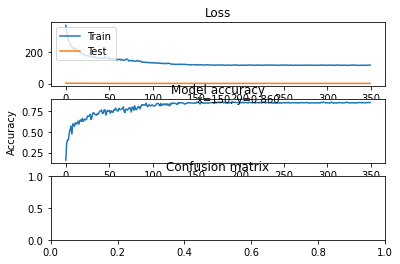

In [13]:
warnings.filterwarnings("ignore", category=UserWarning)

Net = DDNet(C.frame_l, C.joint_n, C.joint_d,
            C.feat_d, C.filters, clc_num)
model = Net.to(device)

model_, preprocess = clip.load(model_text_name, device)
model_text = TextCLIP(model_)
model_text = model_text.cuda(device)

token_list = np.array(text_prompt_openai_random())


#summary(model, [(C.frame_l, C.feat_d), (C.frame_l, C.joint_n, C.joint_d)])
optimizer = optim.Adam(list(model.parameters()) + list(model_text.parameters()), lr=0.001, betas=(0.9, 0.999))

criterion = nn.CrossEntropyLoss()
KLloss = KLLoss().cuda("cuda:0")
scheduler = ReduceLROnPlateau(
    optimizer, factor=0.5, patience=5, cooldown=0.5, min_lr=5e-6, verbose=True)
for epoch in range(1, 350 + 1):

    train_loss = train(args, model,model_text, token_list, device, train_loader,
                        optimizer, epoch, criterion, KLloss)
    test(model, device, test_loader)
    scheduler.step(train_loss)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)
ax1.plot(history['train_loss'])
ax1.plot(history['test_loss'])
ax1.legend(['Train', 'Test'], loc='upper left')
ax1.set_xlabel('Epoch')
ax1.set_title('Loss')

ax2.set_title('Model accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.plot(history['test_acc'])
xmax = np.argmax(history['test_acc'])
ymax = np.max(history['test_acc'])
text = "x={}, y={:.3f}".format(xmax, ymax)
ax2.annotate(text, xy=(xmax, ymax))

ax3.set_title('Confusion matrix')
model.eval()
with torch.no_grad():
    Y_pred = model(X_0_t.to(device), X_1_t.to(
        device)).cpu().numpy()
Y_test = Y_t.numpy()
cnf_matrix = confusion_matrix(
    Y_test, np.argmax(Y_pred, axis=1))
ax3.imshow(cnf_matrix)
fig.tight_layout()
fig.savefig(str(savedir / "perf.png"))
if save_model:
    torch.save(model.state_dict(), str(savedir/"model.pt"))


if False:
    device = ['cpu', 'cuda']
    # calc time
    for d in device:
        tmp_X_0_t = X_0_t.to(d)
        tmp_X_1_t = X_1_t.to(d)
        model = model.to(d)
        # warm up
        _ = model(tmp_X_0_t, tmp_X_1_t)

        tmp_X_0_t = tmp_X_0_t.unsqueeze(1)
        tmp_X_1_t = tmp_X_1_t.unsqueeze(1)
        start = time.perf_counter_ns()
        for i in range(tmp_X_0_t.shape[0]):
            _ = model(tmp_X_0_t[i, :, :, :], tmp_X_1_t[i, :, :, :])
        end = time.perf_counter_ns()
        msg = ("total {}ns, {:.2f}ns per one on {}".format((end - start),
                                                            ((end - start) / (X_0_t.shape[0])), d))
        print(msg)
        logging.info(msg)


In [8]:
prefix = "A person"
list_of_texts = [
    f'{prefix} does nothing.',
    f'{prefix} raises one arm up high, makes a fist, then keeps the fist still, bends the arm to shoulder level, then raises it up again.',
    f'{prefix} places one hand in front of their chest, then moves the arm in the opposite direction.',
    f'{prefix} places their arms vertically and perpendicular to the ground at shoulder level when their arms are bent. Then brings them back to their chest.',
    f'{prefix} raises one hand at chest level, palm facing down, tip of the hand facing out, then presses the hand down to hip level, then lifts the arm up and brings it back to the original position.',
    f'{prefix} places one hand flat on their hip, tip of the hand facing outward. Then, lifts the hand lying face up to chest level, then presses the hand down again and returns to the starting position.',
    f'{prefix} places one arm across their chest, palm facing down, tip of the hand facing the opposite hand. Then, moves their arm along the chest plane at an angle of more than 120 degrees, at which time the tip of their hand points outward. Finally returns their arms to the starting position.',
    f'{prefix} raises one arm overhead, holding the hand, then moves the arm and keeps the holding hand towards the top of the head. Finally, returns their arms to the starting position.',
    f'{prefix} raises one arm horizontally across the chest, vertical and perpendicular to the ground, hand with one index finger pointing up to the sky. Then, moves their arm and index finger up until their arm is at shoulder level. Finally, returns to the original position.',
    f'{prefix} raises one arm, places the hand on one half of the head.',
    f'{prefix} places one arm across their chest, vertical to their body, perpendicular to the ground. Raises their index finger and thumb normally, with their index finger pointing toward the sky.',
    f'{prefix} places their arms in front of their chest, clasps their hands, spreads out only their thumbs, stands up and faces the sky. Holds their hands facing in front of their body.',
    f'{prefix} places their arms in front of their chest, hands open and facing each other, palm tips facing the sky.',
    f'{prefix} places their arms across their chest, their hands close together (about a few centimeters), their palms facing each other.',
    f'{prefix} places one arm in front of their chest, vertical to the body. Palms face out in front of the body, fingers clustered in a claw shape.',
    f'{prefix} places one arm in front of their chest, vertical to the body. Hands clenched.',
    f'{prefix} places their hands across their chest, arms pointing out in front of their body. The hand bends the ring finger and little finger, the middle finger contacts the thumb, and the index finger spreads out naturally.',
    f'{prefix} places one arm across their neck, the arm horizontally perpendicular to the body axis, the tip of the hand facing the opposite shoulder. The other arm places the hand in front of the chest perpendicular to the palm of the other hand, the tip of the hand facing up.',
    f'{prefix} places one hand on the opposite shoulder, arms spread out with five fingers embracing one shoulder.',
    f'{prefix} places one hand on the opposite shoulder, placing the hand close to the shoulder. Holds the 3 thumbs, ring finger and little finger, and spreads the index and middle fingers.',
]


In [ ]:
labels = ['No gesture']+a
for x,i in enumerate(list_of_texts):
    #print(x+1,"&", labels[x],"&", i, " \\\ \hline")
    print(i)

1 & No gesture & A person does nothing.  \\ \hline
2 & Start & A person raises one arm up high, makes a fist, then keeps the fist still, bends the arm to shoulder level, then raises it up again.  \\ \hline
3 & Stop & A person places one hand in front of their chest, then moves the arm in the opposite direction.  \\ \hline
4 & Slower & A person places their arms vertically and perpendicular to the ground at shoulder level when their arms are bent. Then brings them back to their chest.  \\ \hline
5 & Faster & A person raises one hand at chest level, palm facing down, tip of the hand facing out, then presses the hand down to hip level, then lifts the arm up and brings it back to the original position.  \\ \hline
6 & Done & A person places one hand flat on their hip, tip of the hand facing outward. Then, lifts the hand lying face up to chest level, then presses the hand down again and returns to the starting position.  \\ \hline
7 & FollowMe & A person places one arm across their chest, pa